In [1]:
# Dense gas fraction with SMA in CMZoom
# Borrowing from dense_gas_fraction_2018_hatchfield.ipynb
# and Mills_SMA_Share.ipynb

In [2]:
# Data path
path='/Users/battersby/Dropbox/CMZoom_Data/'
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import aplpy
#from math import *
from astropy import units as u
from astropy.table import QTable, Table, Column, MaskedColumn
from astropy.io import ascii
from astropy.wcs import WCS
from reproject import reproject_exact
import re
from astropy.stats import mad_std
import os.path
from matplotlib import collections  as mc
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
import matplotlib
import sys
sys.path.append(path+'/dense_gas_fraction/dgf_comparison')
import histograms

In [3]:
# Load in various fits files.

# Figure Path
pathfig='/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/10383815hfwsykpqhnrx/figures/'
pathtable='/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/10383815hfwsykpqhnrx/tables/'

# Data path
path='/Users/battersby/Dropbox/CMZoom_Data/'

# CMZoom data
#cmzoomfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/Final/Pb_corrected/'+'CMZoom_continuum_mosaic_no_SgrA.fits')
#cmzoomfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/Actual_Final/'+'CMZoom_continuum_pbcor.fits')
cmzoomfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/March_2020/'+'CMZoom_continuum_pbcor.fits')
cmzoom=cmzoomfits[0].data
cmzoomhdr=cmzoomfits[0].header
cmzoomWCS = WCS(cmzoomhdr)

#CMZoom feathered
featheredfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/Actual_Final/'+'CMZoom_continuum_pbcor_feathered.fits')
#featheredfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/March_2020/'+'CMZoom_continuum_pbcor_feathered.fits')
feathered=featheredfits[0].data
#featherhdr=featheredfits[0].header
#cmzoomWCS = WCS(cmzoomhdr)

# CMZoom residual
#residualfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/Final/Pb_corrected/'+'CMZoom_residual_mosaic_no_SgrA.fits')
#residualfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/Actual_Final/'+'CMZoom_residual_pbcor.fits')
residualfits=fits.open(path+'continuum_images/Final_continuum_images/Mosaics/March_2020/'+'CMZoom_residual_pbcor.fits')
residual=residualfits[0].data

#CMZoom noise map
sma_noise_fits=fits.open(path+'final_catalog/high_reliability/CMZoom_noisemap_JySr_k14_final.fits')
sma_noise=sma_noise_fits[0].data

# BGPS data
bgpsfits=fits.open(path+'Comparison_Data/'+'BGPS_v2.0_super_gc_13pca_map20_reproject.fits')
bgps=bgpsfits[0].data
bgpshdr=bgpsfits[0].header

# Herschel Data
herschelfits=fits.open(path+'Comparison_Data/spitzer_and_herschel/'+'column_properunits_conv36_source_only.fits')
#herscheltempfits = fits.open(path+'Comparison_Data/spitzer_and_herschel/'+'gaussfit_iter_beta175_temp_gc_itervar_conv36.fits')
herscheltempfits = fits.open(path+'Comparison_Data/spitzer_and_herschel/'+'herschel_temperature_conv36.fits')


In [4]:
# CMZoom Mask
if os.path.exists(path+'dense_gas_fraction/CMZoom_Mask_new_NaNs.fits'):
    maskfits=fits.open(path+'dense_gas_fraction/CMZoom_Mask_new_NaNs.fits')
    mask=maskfits[0].data
    maskhdr=maskfits[0].header
else: 
    maskfits=fits.open(path+'dense_gas_fraction/CMZoom_Mask_new.fits')
    mask=maskfits[0].data
    maskhdr=maskfits[0].header
    mask[mask>50] = float('NaN')
    fits.writeto(path+'dense_gas_fraction/CMZoom_Mask_new_NaNs.fits', data=mask, header=maskhdr, overwrite=True)
#only need to do this once, the freaking 1000s are very annoying

### Update Feb. 2020, the below was run once, uncomment if needed, but should NEVER need.:
#One more mask modification. Right now, the mask extends beyond the residual noise, so edges are very noisy
#and overall very bad for science. Move former mask to "CMZoom_Mask_Jan2020" in "older_cmzoom_masks"
# and "CMZoom_Mask_edge_problem_NaNs" to start out with.
#maskfits = fits.open(path+'dense_gas_fraction/CMZoom_Mask_edge_problem_NaNs.fits')
#mask = maskfits[0].data
#mask[np.isnan(sma_noise)]=float('NaN')
#fits.writeto(path+'dense_gas_fraction/CMZoom_Mask_new_NaNs.fits', data=mask, header=maskhdr, overwrite=True)

### For testing using SgrC dense as one data point
maskfits=fits.open(path+'dense_gas_fraction/sgrc/mask_new_sgrc_NaNs.fits')
mask=maskfits[0].data
maskhdr=maskfits[0].header

### Only use part of CMZoom data where the noise map exists
# Get rid of pixels that *exist* in the SMA data map but *not* in the noise map
# (some minor flaw we're not sure how arises, but only a few pixels on the edge)
cmzoom[np.isnan(sma_noise)]=float('NaN')
feathered[np.isnan(sma_noise)]=float('NaN')



In [5]:
# Reproject herschel (N(H2) and temperature) and BGPS data to the same pixel scale as the SMA CMZoom data

if os.path.exists(path+'dense_gas_fraction/Herschel_sma_pix.fits'):
    file = fits.open(path+'dense_gas_fraction/Herschel_sma_pix.fits')
    nh2 = file[0].data
    filetemp = fits.open(path+'dense_gas_fraction/Herscheltemp_sma_pix.fits')
    temp = filetemp[0].data
else:
    nh2, footprint = reproject_exact(herschelfits, cmzoomhdr)
    fits.writeto(path+'dense_gas_fraction/Herschel_sma_pix.fits', data=nh2, header=cmzoomhdr, overwrite=True)
    temp, footprint = reproject_exact(herscheltempfits, cmzoomhdr)
    fits.writeto(path+'dense_gas_fraction/Herscheltemp_sma_pix.fits', data=temp, header=cmzoomhdr, overwrite=True)

if os.path.exists(path+'dense_gas_fraction/BGPS_sma_pix.fits'):
    file = fits.open(path+'dense_gas_fraction/BGPS_sma_pix.fits')
    bgps_sma = file[0].data
else:
    bgps_sma, footprint2 = reproject_exact(bgpsfits, cmzoomhdr)
    fits.writeto(path+'dense_gas_fraction/BGPS_sma_pix.fits', data=bgps_sma, header=cmzoomhdr, overwrite=True)

In [6]:
# Create a boolean masked array of the CMZoom pixel locations and write to a fits file
# Note that a=b means b follows a! weird. hence, mask_ones=np.copy(mask)

mask_ones = np.copy(mask)
mask_ones[mask_ones < 50] = 1.0

fits.writeto(path+'dense_gas_fraction/Mask_ones.fits', data=mask_ones, header=cmzoomhdr, overwrite=True)

/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [7]:
# Correct for the difference in frequency between BGPS and SMA CMZoom, by 
# Flux density goes as nu^(2+beta)
# (Rayleigh Jean's limit, Snu ~ nu^2 * (1-e^-tau_nu)...
# then optically thin limit, Snu ~ nu^2 * tau_nu...
# tau_nu ~ nu^beta
# So, Snu ~ nu(2+beta))

nu_bgps = 271.1e9 # GHz from Aguirre et al. 2011
nu_sma = 224.9e9 # GHz from SMA bottom LSB 216.9 to top USB 232.9 GHz. Right in the middle.
beta = 1.75 # Battersby et al. 2011

bgps_corr = bgps_sma*mask_ones*((nu_sma/nu_bgps)**(2+beta))

#need to do same for bgps_noise = 45 mJy/beam (average)
bgps_rms = 50.0e-3 * ((nu_sma/nu_bgps)**(2+beta)) #mJy/beam to Jy/beam 
# check Fig. 1 of Ginsburg 2013, about 50 mJy per pixel in the galactic center seems fair

In [8]:
# Just a printout of the correction factor for the BGPS data to 
# match the central frequency of the SMA data
print(((nu_sma/nu_bgps)**(2+beta)))

0.4962777070105076


In [9]:
# BGPS flux should be lower after correction (about a factor of 2).
# This works fine.
print(np.nanmean(bgps_corr))
print(np.nanmean(bgps_sma*mask_ones))
print(bgps_rms)

0.8596943498732222
1.7322848432017508
0.02481388535052538


In [10]:
# Figure out units of both
print(cmzoomhdr['BUNIT'])
print(bgpsfits[0].header['BUNIT'])
print(sma_noise_fits[0].header['BUNIT'])

Jy/sr
Jy/Beam
Jy/sr


In [11]:
# Convert BGPS from Jy/beam to Jy/pixel
# Jy/pixel = Jy/beam * (beam/sq as) * (sq as / pixel)
# Jy/pixel = Jy/beam * (beam/sq deg) * (sq deg / pixel) # or as here, all in deg^2, so just use that.
bgps_pix = bgps_corr * (1/(bgpshdr['BMAJ']*bgpshdr['BMIN'])) * ((np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])))
cmzoomhdr['BUNIT'] = 'Jy/pixel'
#cmzoomhdr BUNIT IS changed and wrong for old data FYI!
fits.writeto(path+'dense_gas_fraction/BGPS_jypix.fits', data=bgps_pix, header=cmzoomhdr, overwrite=True)
bgps_noise = bgps_rms * (1/(bgpshdr['BMAJ']*bgpshdr['BMIN'])) * ((np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])))

# Convert SMA from Jy/Sr to Jy/pixel for the SMA data, residual, noise map, and feathered map.
# Jy/pixel = Jy/Sr * Sr/pixel (deg * 2pi rad / 360deg = radian)
sma_pix = np.copy(cmzoom) * (np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])) * (2*np.pi / 360)**2
fits.writeto(path+'dense_gas_fraction/CMZoom_jypix.fits', data=sma_pix, header=cmzoomhdr, overwrite=True)
#residual_pix = residual * (np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])) * (2*np.pi / 360)**2
sma_noise_pix = np.copy(sma_noise) * (np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])) * (2*np.pi / 360)**2
feathered_pix = np.copy(feathered) * (np.absolute(cmzoomhdr['CDELT1'])*np.absolute(cmzoomhdr['CDELT2'])) * (2*np.pi / 360)**2


## Do this earlier on now... 4th cell
# Get rid of pixels that *exist* in the SMA data map but *not* in the noise map
# (some minor flaw we're not sure how arises, but only a few pixels on the edge)
#sma_pix[np.isnan(sma_noise_pix)]=float('NaN')
#feathered_pix[np.isnan(sma_noise_pix)]=float('NaN')

# makes a *huge* difference what you sum over (everything above 0, or above 1 sigma, or above 2 sigma...)
# Okay, after investigating by eye (10/25/19), I think that counting pixels above 2 sigma is the lowest we can go
# Two sigma cut
sma_pix_2sigma=np.copy(sma_pix)
sma_pix_2sigma[sma_pix_2sigma < (2*sma_noise_pix)]=float('NaN')
bgps_pix_2sigma=np.copy(bgps_pix)
bgps_pix_2sigma[bgps_pix_2sigma < (2*bgps_noise)]=float('NaN')

# One sigma cut
sma_pix_1sigma=np.copy(sma_pix)
sma_pix_1sigma[sma_pix_1sigma < (1*sma_noise_pix)]=float('NaN')
bgps_pix_1sigma=np.copy(bgps_pix)
bgps_pix_1sigma[bgps_pix_1sigma < (1*bgps_noise)]=float('NaN')

# Three sigma cut
sma_pix_3sigma=np.copy(sma_pix)
sma_pix_3sigma[sma_pix_3sigma < (3*sma_noise_pix)]=float('NaN')
bgps_pix_3sigma=np.copy(bgps_pix)
bgps_pix_3sigma[bgps_pix_3sigma < (3*bgps_noise)]=float('NaN')


/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less


In [12]:
## Get total SMA and BGPS flux within each mask (this only works if mask value is an integer)
# A very IDL way to do things, methinks. Meh, it works! Leave it.

nel = int(np.nanmax(mask)) # number of elements in the mask is the maximum mask value

plot_ratio1sig = np.copy(mask) #Make a copy of the mask array to drop values of the SMA/Bolocam ratio into
plot_ratio1sig = 0.0*plot_ratio1sig #Initialize it
S_flux1sig=np.zeros(nel) #Initialize other variables
B_flux1sig=np.zeros(nel)

plot_ratio2sig = np.copy(mask) #Make a copy of the mask array to drop values of the SMA/Bolocam ratio into
plot_ratio2sig = 0.0*plot_ratio2sig #Initialize it
S_flux2sig=np.zeros(nel) #Initialize other variables
B_flux2sig=np.zeros(nel)

plot_ratio3sig = np.copy(mask) #Make a copy of the mask array to drop values of the SMA/Bolocam ratio into
plot_ratio3sig = 0.0*plot_ratio2sig #Initialize it
S_flux3sig=np.zeros(nel) #Initialize other variables
B_flux3sig=np.zeros(nel)
Hnh2med=np.zeros(nel)

for i in np.arange(0,nel): # Loop through each mask
    S_flux1sig[i] = np.nansum(sma_pix_1sigma[mask==i+1]) # Sum SMA above pre-defined sigma level
    B_flux1sig[i] = np.nansum(bgps_pix_1sigma[mask==i+1]) # Sum bolocam above pre-defined sigma level
    plot_ratio1sig[(mask==i+1)] = (S_flux1sig[i]/B_flux1sig[i]) #Fill each mask with the ratio of SMA to Bolocam
    
    S_flux2sig[i] = np.nansum(sma_pix_2sigma[mask==i+1]) # Sum SMA above pre-defined sigma level
    B_flux2sig[i] = np.nansum(bgps_pix_2sigma[mask==i+1]) # Sum bolocam above pre-defined sigma level
    plot_ratio2sig[(mask==i+1)] = (S_flux2sig[i]/B_flux2sig[i]) #Fill each mask with the ratio of SMA to Bolocam
    
    S_flux3sig[i] = np.nansum(sma_pix_3sigma[mask==i+1]) # Sum SMA above pre-defined sigma level
    B_flux3sig[i] = np.nansum(bgps_pix_3sigma[mask==i+1]) # Sum bolocam above pre-defined sigma level
    plot_ratio3sig[(mask==i+1)] = (S_flux3sig[i]/B_flux3sig[i]) #Fill each mask with the ratio of SMA to Bolocam
    Hnh2med[i]=np.nanmedian(nh2[mask==i+1])
    
### Save plot ratios as fits files for visual inspection
fits.writeto(path+'dense_gas_fraction/SMA_to_BGPS_ratio_2sigma.fits', data=plot_ratio2sig, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_to_BGPS_ratio_3sigma.fits', data=plot_ratio3sig, header=cmzoomhdr, overwrite=True)


### Add in one weird SgrC denser region point
### SET MASK TO 
S_flux3sig_SgrC = np.nansum(sma_pix_3sigma[mask==i+1]) # Sum SMA above pre-defined sigma level
B_flux3sig_SgrC = np.nansum(bgps_pix_3sigma[mask==i+1]) # Sum bolocam above pre-defined sigma level
plot_ratio3sig_SgrC = (S_flux3sig_SgrC/B_flux3sig_SgrC) #Fill each mask with the ratio of SMA to Bolocam
Hnh2med_SgrC=np.nanmedian(nh2[mask==i+1])


<IPython.core.display.Javascript object>


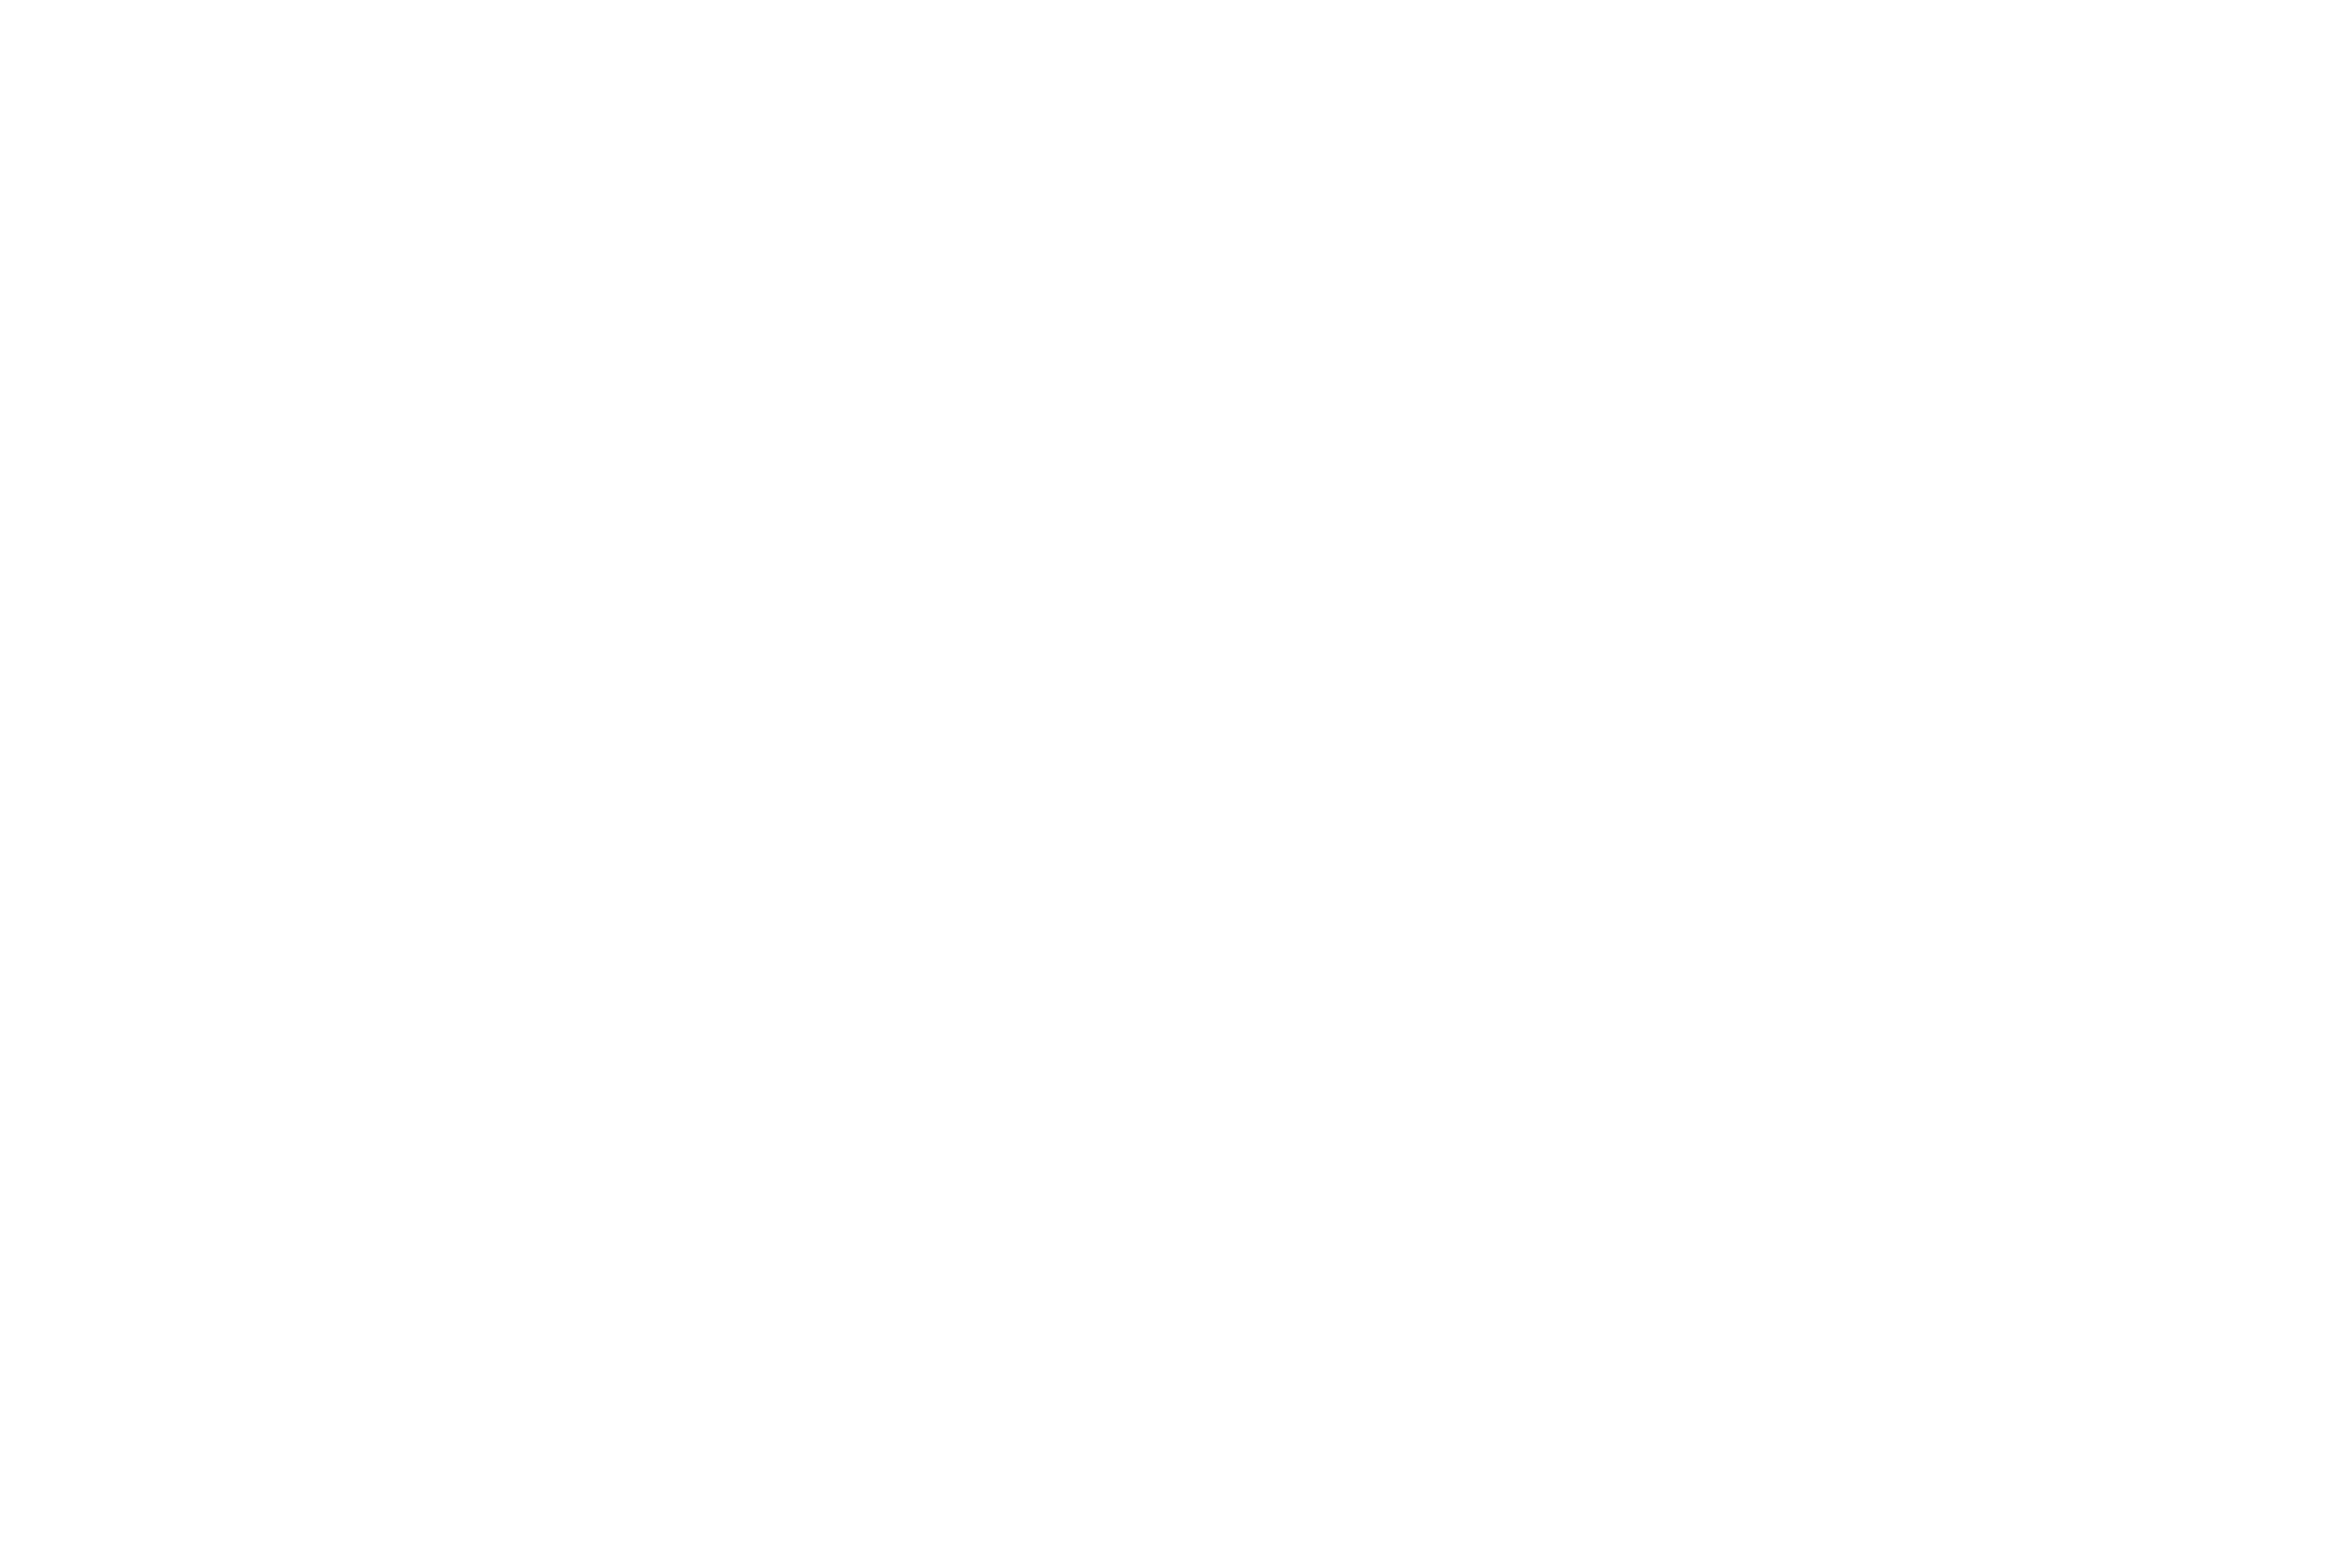

/Users/battersby/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/battersby/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [13]:
# Plot the ratio of SMA flux to BGPS flux  (remember, highly dependent on sigma cut!)
# 3 sigma
%matplotlib nbagg 

plt.rcParams.update({'font.size': 12}) #set fontsize

#Previous, works fine, but can't get units to 'dd.d' ...
fig, ax = plt.subplots(figsize=(12, 8))
ax = plt.subplot(projection=cmzoomWCS)
lon = ax.coords['glon']
lon.set_major_formatter('d.dd')
lat = ax.coords['glat']
lat.set_major_formatter('d.dd')

#Plot 3 sigma with colorbar and 2 sigma without so I can make a mutliplot in latex
cax = ax.imshow(plot_ratio3sig, norm=LogNorm(vmin=0.01, vmax=0.5), cmap='viridis')

#plt.text(+1.5, -0.05, 'All pixels above 3 $\sigma$', color='black')#,alpha=alpha) 
plt.text(+1.65, 0.09, 'All pixels above 3 $\sigma$', color='black', transform=ax.get_transform('galactic'))#,alpha=alpha) 

# Plot a scalebar
gcdist = 8.15e3 #pc
dgper1pc = (1.0/gcdist)*(360.0/(2.0*np.pi))
dgper100pc = dgper1pc*100.0
#scalebar100pc = np.array([[1.5,(1.5-dgper100pc)],[-0.15,-0.15]]) 
#fig.show_lines([scalebar100pc], color='black', alpha=0.65)
xsbar = np.array([1.6, 1.6-dgper100pc])
ysbar = np.array([-0.20, -0.20])
plt.plot(xsbar, ysbar, color='black', alpha=0.65, transform=ax.get_transform('galactic'))
plt.text(1.4, -0.26, '100 pc', color='black', alpha=0.65, transform=ax.get_transform('galactic'))

#ax.set_title('Dense Gas Fraction, SMA Flux / BGPS Flux')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
#plt.xlim(1.9, 359.0 hdu.data.shape[1] - 0.5))#, transform=ax.get_transform('galactic'))
#ax.set_xlim
#left, right = plt.xlim()
#print(plt.xlim())
#-5000.0, 20000.0
#pint(plt.ylim())
#(-500.0, 3000.0)
plt.xlim(-400.0, 20000.0)
plt.ylim(-100.0, 3200.0)
#WHAT MAGIC IS THIS?!? Can't figure out how to do it in data coordinates with a transform, so OH WELL.
top, bottom = plt.ylim()


#Plot ticks as I choose, rather than the base only
# (from: https://stackoverflow.com/questions/27345005/log-labels-on-colorbar-matplotlib)
formatter = LogFormatter(10, labelOnlyBase=False) 
cbar = fig.colorbar(cax, ticks=[0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], format=formatter, orientation='horizontal')
cbar.ax.set_xticklabels(['5%','10%','20%','30%','40%','50%','75%','100%'])
#cbar.ax.set_title('Dense Gas Fraction = SMA Flux / BGPS Flux')
cbar.ax.set_title('Method 1 CDGF = SMA Flux / BGPS Flux')

plt.show()
plt.savefig(pathfig+'CMZoom_dense_gas_fraction_3sigma.pdf',
            format='pdf', dpi=500, bbox_inches='tight')#, pad_inches=0.1)


<IPython.core.display.Javascript object>


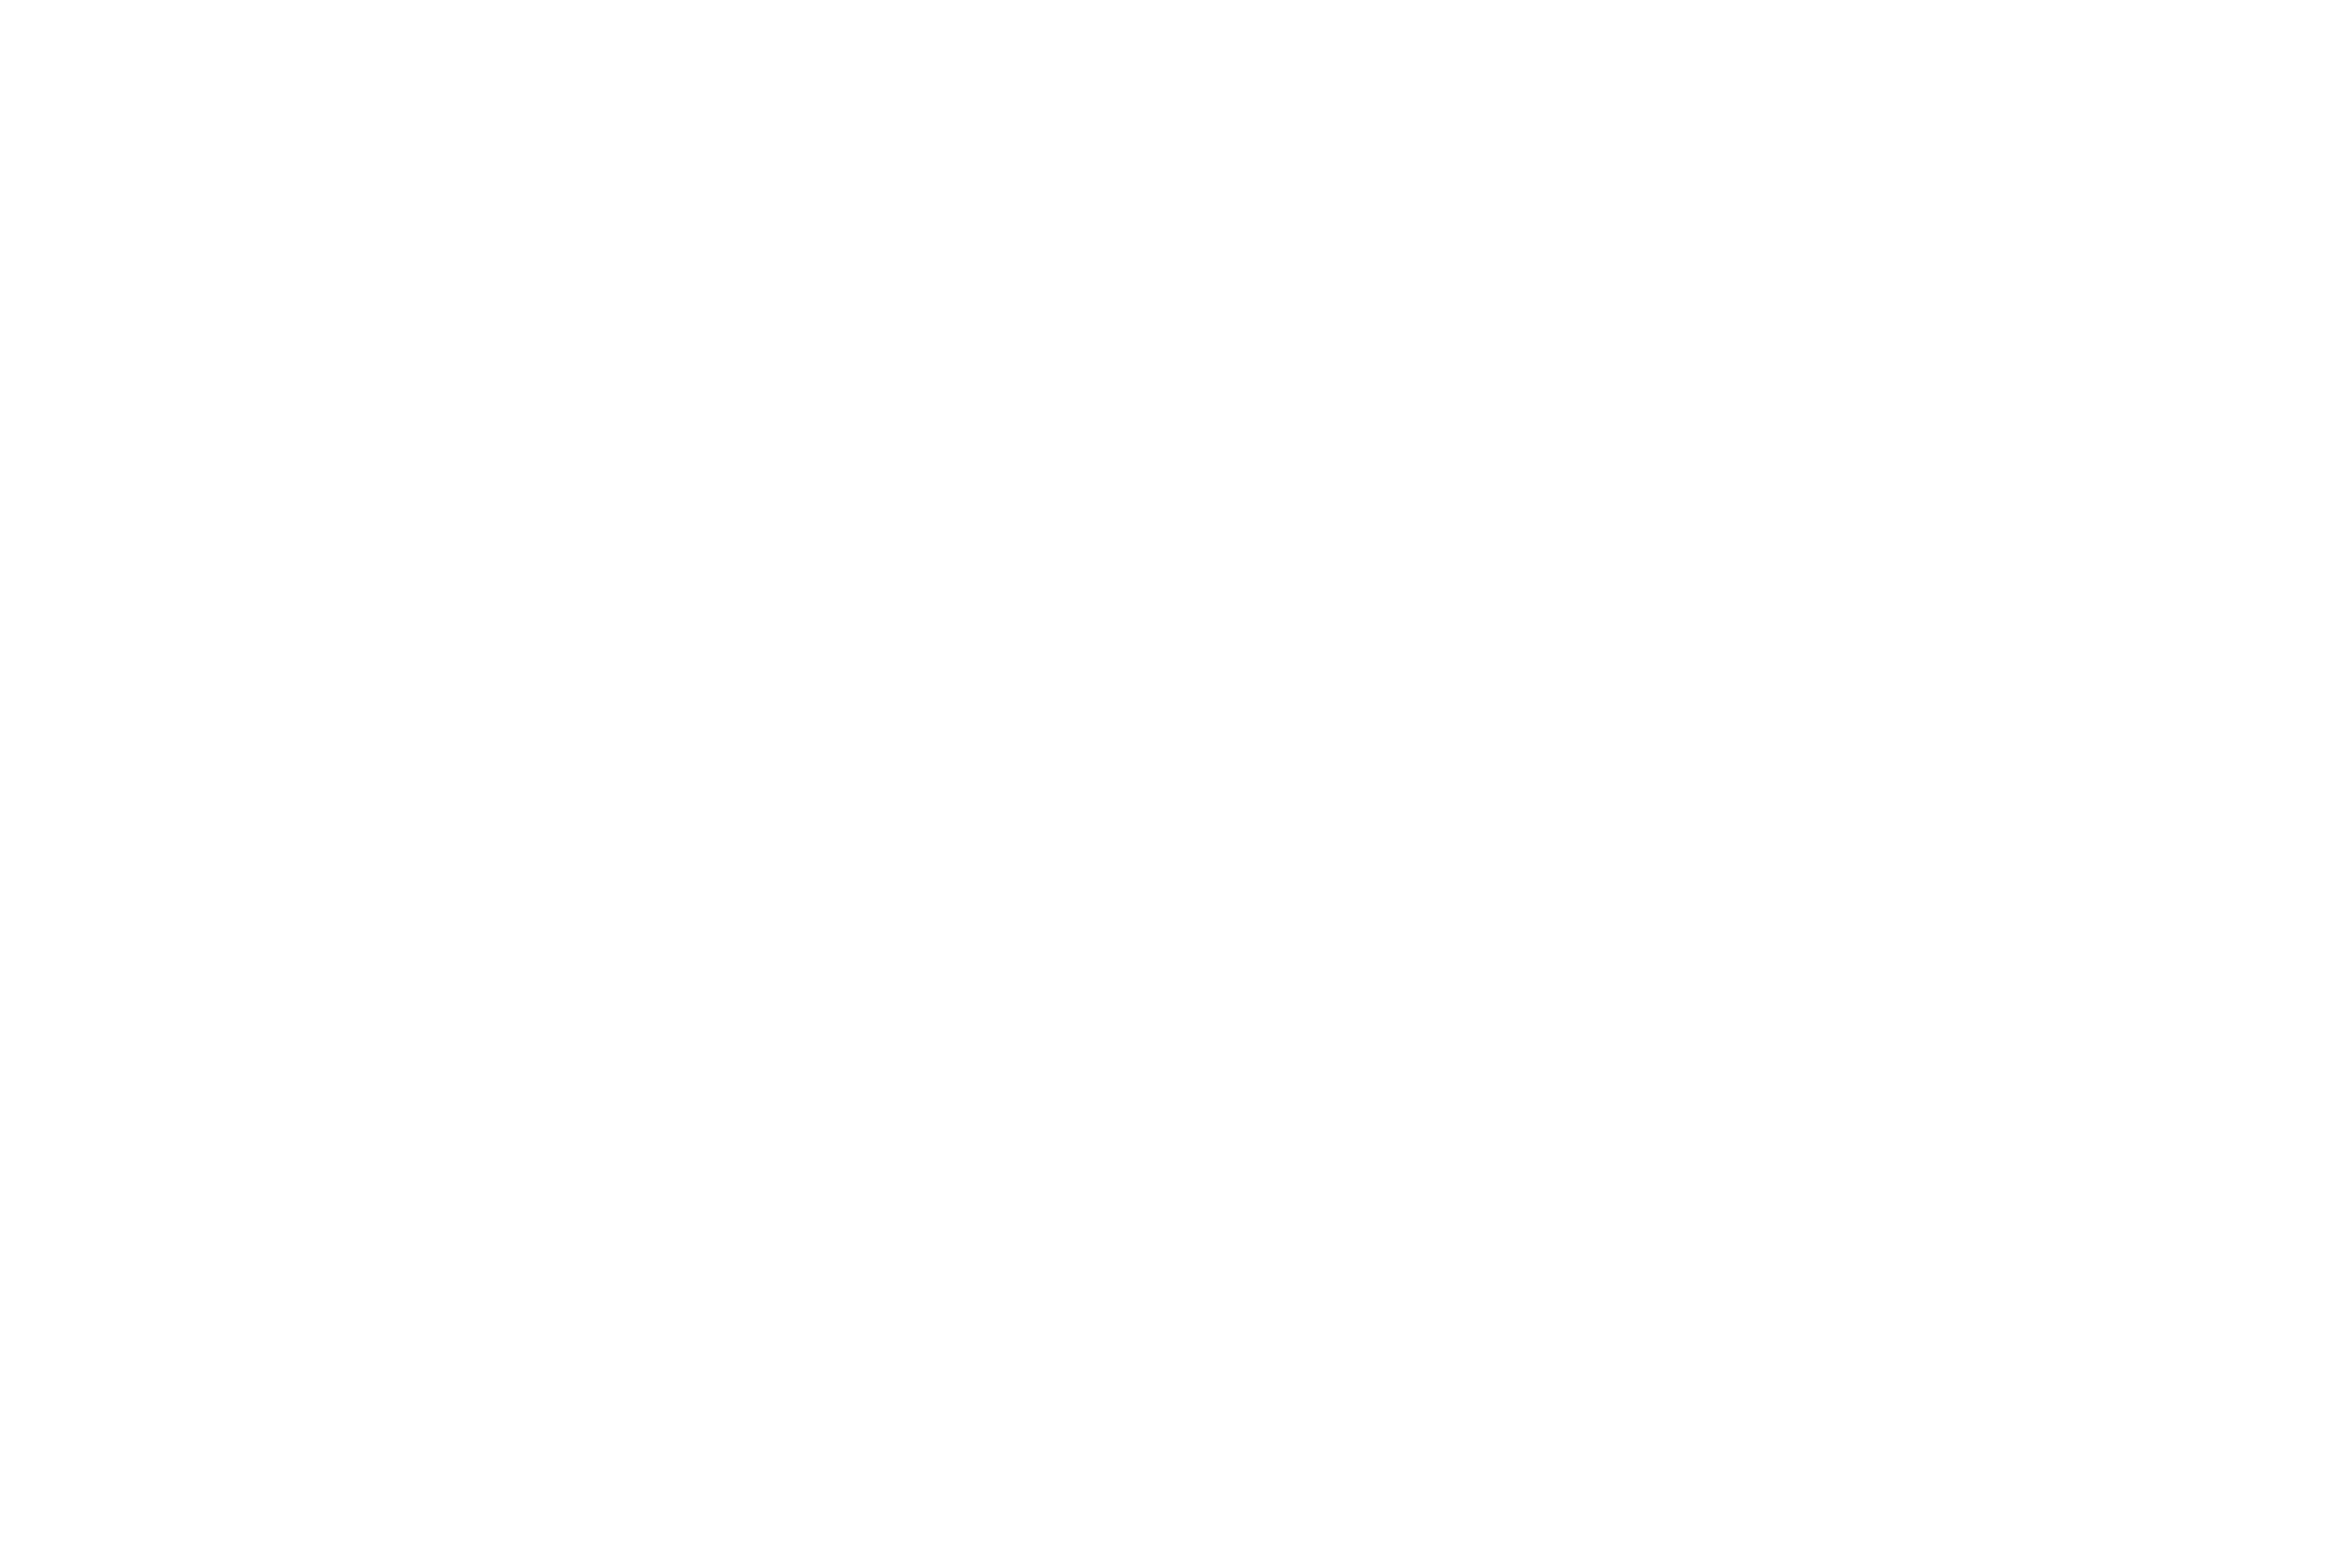

/Users/battersby/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/battersby/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


In [14]:
# Plot the ratio of SMA flux to BGPS flux  (remember, highly dependent on sigma cut!)
# 2 sigma
%matplotlib nbagg 

plt.rcParams.update({'font.size': 12}) #set fontsize

fig, ax = plt.subplots(figsize=(12, 8))
ax = plt.subplot(projection=cmzoomWCS)

#Plot 3 sigma with colorbar and 2 sigma without so I can make a mutliplot in latex
cax = ax.imshow(plot_ratio2sig, norm=LogNorm(vmin=0.01, vmax=0.5), cmap='viridis')

plt.text(+1.5, -0.05, 'All pixels above 2 $\sigma$', color='black')#,alpha=alpha) 

#ax.set_title('Dense Gas Fraction, SMA Flux / BGPS Flux')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

#Plot ticks as I choose, rather than the base only
# (from: https://stackoverflow.com/questions/27345005/log-labels-on-colorbar-matplotlib)
#formatter = LogFormatter(10, labelOnlyBase=False) 
#cbar = fig.colorbar(cax, ticks=[0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], format=formatter, orientation='horizontal')
#cbar.ax.set_xticklabels(['5%','10%','20%','30%','40%','50%','75%','100%'])
#cbar.ax.set_title('Dense Gas Fraction = SMA Flux / BGPS Flux')# Above 2 $\sigma$')

plt.show()

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_dense_gas_fraction_2sigma.pdf',
            format='pdf', dpi=500, bbox_inches='tight')#, pad_inches=0.1)


In [15]:
# Now dense gas fraction per column density bin.
# Calculate total mass of each cloud in Herschel
# Then calculate the fraction of total SMA mass in column density bins
# from 5x10^22 - 5x10^24 cm^-2
# (but what does this mean for a point source, which would have some % low density and some % high density bc of beam?)


In [16]:
# Constants (and dust property assumptions) for
# conversion from flux to column and mass

# Assumptions
T = 20. #15.
kappa = 0.01*4.0*(nu_sma/505e9)**1.75 # cm^2/g
#kappa above from Battersby et al. 2011 (pg 6), but multiplied by 0.01 
#for dust to gas ratio of 100 
#distance = 8340 #pc Reid 2014
distance = 8150 #pc Reid 2019 udpated
dm = distance*3.086e16 #distance in m
dcm = distance*3.086e18 # distance in cm

# Constants
c = 2.9979e8 # m/s
h = 6.626e-34
nu_sma = 224.9e9 #Hz central frequency of SMA observations
mu = 2.8 # Kauffman et al. 2008 appendix (mean molecular weight of molecular gas)
mh = 1.67e-27 # kg
msun = 1.99e30 #kg
k = 1.38e-23 #SI

In [17]:
## Define Blackbody Function
#(SI units)
def BBody(nu,T):
    return (2*h*(nu_sma**3))/((c**2)*(np.exp((h*nu)/(k*T))-1.))

## Convert the flux in Jy to a column density in cm^-2
# Assuming dust properties (kappa, mu, nu, T).
# This assumes optically thin dust. Snu = BBody*(1-e^-tau_nu), tau_nu = mu*mh*kappa*N(H2)
# So, N(H2) = Snu / (BB * mu * mh * kappa). Snu and BB should match units. 
# BB is SI fully and S_Jy is too, but off by 1e-26 (1 Jy = 1e-26 J/ (s * m^2 * Hz)) - so multiply S_Jy by 1e-26
# Then kappa is cm^2/g and mh is kg, so multiply kappa by 1000 to get just cm^-2 in the end
#S is in Jy/Sr, nu in Hz, T in K, and column in cm^-2
def findColumn(S_Jy, nu, T):
    return ((S_Jy*1e-26)/(kappa*1000.*mu*mh*BBody(nu,T)))

# Now convert column density to mass
#column is in cm^-2, pix_area_cm is the pixel area in cm^2, and mass is solar masses
def findMass(column, pix_area_cm2):
    return (column * mh * mu * pix_area_cm2 / msun)


In [18]:
### Convert Herschel N(H2) (number of H2 atoms per cm^-2) to Msun/pix

# Get pixel area in square centimeter
pixx_cm = dcm*(np.absolute(cmzoomhdr['CDELT1'])*3600./206265) # distance in cm * angle in radians
pixy_cm = dcm*(np.absolute(cmzoomhdr['CDELT2'])*3600./206265)
pix_area_cm2 = pixx_cm*pixy_cm

# Convert N(H2) to Mass
mass_herschel = findMass(nh2, pix_area_cm2)
fits.writeto(path+'dense_gas_fraction/Herschel_Msun_per_pix.fits', data=mass_herschel, header=cmzoomhdr, overwrite=True)

In [19]:
print(np.nanmedian(feathered))
print(np.nanmedian(cmzoom))

feathered_column = findColumn(feathered, nu_sma, temp)
fits.writeto(path+'dense_gas_fraction/SMA_feathered_NH2_per_pix.fits', data=feathered_column, header=cmzoomhdr, overwrite=True)
q = findColumn(cmzoom, nu_sma, temp)

print(np.nanmedian(q))
print(np.nanmedian(feathered_column))

27257460.966487214
132821.0407673656
1.0992739840087382e+20
2.4110234504624106e+22


In [20]:
#### Converting SMA flux to Msun / pix and saving

# Convert SMA flux to Msun/pix
#(pix area is the same herschel, since we re-gridded them)
# sma_pix is the SMA flux in units of Jy/pixel
# and cmzoom is the SMA flux in units of Jy/Sr
# sma_noise is the SMA noise in units of Jy/Sr and sma_noise_pix is in units of Jy/pixel
# residual_pix is the SMA noise in units of Jy/pixel
# feathered is the feathered image in Jy/Sr, feathered_pix is in Jy/pixel

### Fixed so T is pulled from Herschel temperature map!
# Verified to work on 12/24/19
sma_column = findColumn(cmzoom, nu_sma, temp)
sma_mass = findMass(sma_column, pix_area_cm2)
sma_noise_column = findColumn(sma_noise, nu_sma, temp)
sma_noise_mass = findMass(sma_noise_column, pix_area_cm2)
feathered_column = findColumn(feathered, nu_sma, temp)

/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


<IPython.core.display.Javascript object>


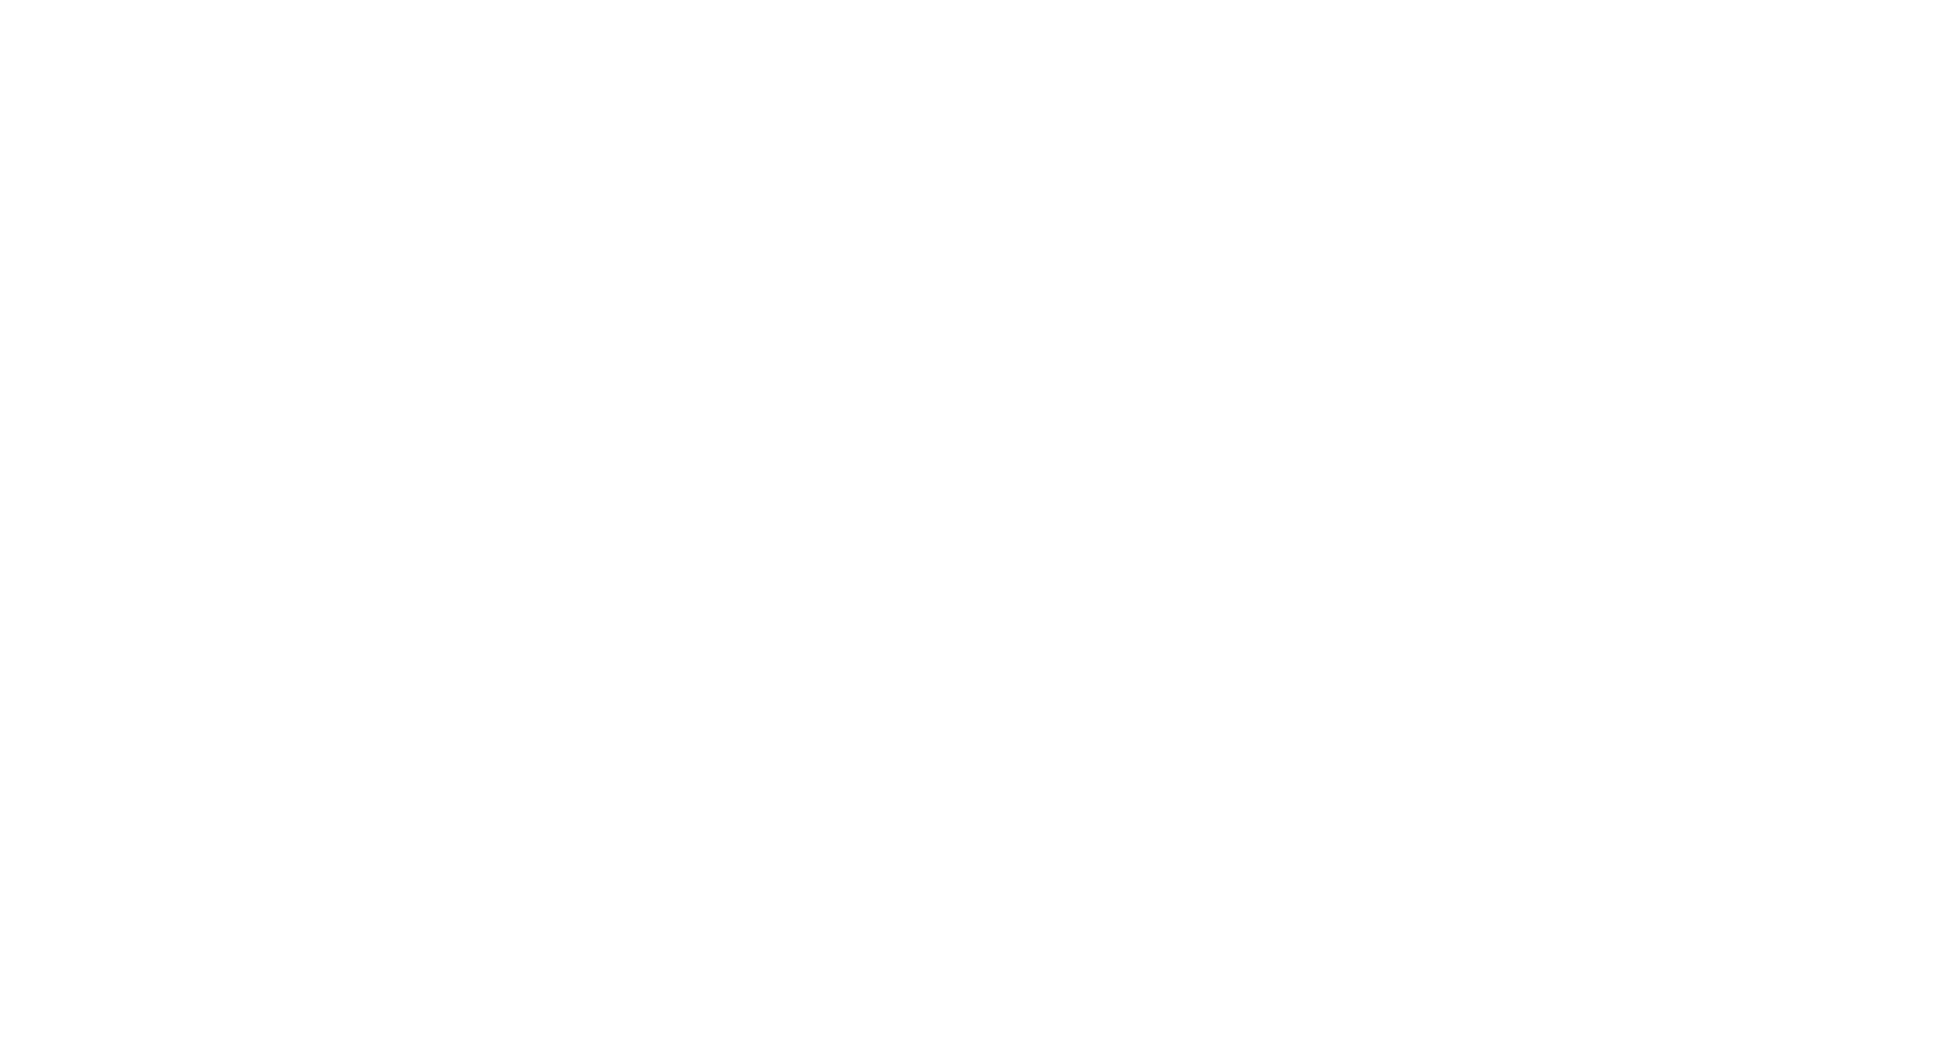

In [21]:
### TWO SIGMA

# Only take pixels above 2 sigma (order here is important! doy.)
sma_mass2sig = np.copy(sma_mass)
sma_column2sig = np.copy(sma_column)
sma_mass2sig[sma_column <= (2.*sma_noise_column)]=float('NaN')  
sma_column2sig[sma_column <= (2.*sma_noise_column)]=float('NaN')  

# Write to files for further inspection
fits.writeto(path+'dense_gas_fraction/SMA_NH2_per_pix.fits', data=sma_column, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_Msun_per_pix_2sigma.fits', data=sma_mass2sig, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_NH2_per_pix_2sigma.fits', data=sma_column2sig, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_Msun_Herschel_Msun_per_pix_2sigma.fits', data=sma_mass2sig/mass_herschel, 
            header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_noise_NH2_pix.fits', data=sma_noise_column, 
            header=cmzoomhdr, overwrite=True)

#### CALCULATING

# SMA Mass Percent = smp ==> Percentage of SMA mass above this column density / Herschel Mass 
# smpsma ==> Percentage of SMA mass above this column density / Total SMA Mass
# sma_herschel ==> Percentage of total SMA mass / Total Herschel Mass
# Units of nh2 = 1e22 cm^-2, so smp5 = 5x10^22, smp50 = 5x10^23

# First get total SMA and Herschel masses for each cloud
mtot = np.zeros(nel)
sma_tot = np.zeros(nel)
for i in np.arange(0,nel):
    sma_tot[i] = np.nansum(sma_mass2sig[(mask==i+1)*(sma_column2sig > 0)]) # Be aware of this sma_column >0! we don't use this here.
    #mtot[i] = np.nansum(mass_herschel[(mask==i+1)*(sma_column > 0)]) #only where sma_column >0
    mtot[i] = np.nansum(mass_herschel[(mask==i+1)]) #everything in the mask

# Now, get the total SMA mass above each column density threshold
def getSMP(sma_column, mass_herschel, sma_mass, factor):
    smp = np.zeros(nel)
    smacloudmass = np.zeros(nel)
    smpsma = np.zeros(nel)
    sma_herschel = np.copy(mask)
    sma_herschel=0.0*sma_herschel
    for i in np.arange(0,nel):
        smacloudmass[i] = np.nansum(sma_mass[(mask==i+1)*(sma_column >= factor*1e22)])
        smp[i] = (smacloudmass[i]/mtot[i])
        smpsma[i] = (smacloudmass[i]/sma_tot[i])
        sma_herschel[mask==i+1] = (sma_tot[i]/mtot[i])
    return smp, smpsma, sma_herschel, smacloudmass, mtot

smp1_2sig, smpsma1_2sig, sma_herschel_2sig, smacloudmass1_2sig, mtot1 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 1.0)
smp5_2sig, smpsma5_2sig, sma_herschel_2sig, smacloudmass5_2sig, mtot5 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 5.0)
smp7_2sig, smpsma7_2sig, sma_herschel_2sig, smacloudmass7_2sig, mtot7 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 7.0)
smp10_2sig, smpsma10_2sig, sma_herschel_2sig, smacloudmass10_2sig, mtot10 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 10.0)
smp50_2sig, smpsma50_2sig, sma_herschel_2sig, smacloudmass50_2sig, mtot50 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 50.0)
smp100_2sig, smpsma100_2sig, sma_herschel_2sig, smacloudmass100_2sig, mtot100 = getSMP(sma_column2sig, mass_herschel, sma_mass2sig, 100.0)


#### PLOTTING

# Plot the column density fractions of SMA mass / Herschel mass as a BAR Graph
# With Cloud name instead of number
%matplotlib nbagg

plt.style.use('classic')
#plt.style.use('seaborn-colorblind')
#plt.style.use('battersbot-colorblind')

num_colors = 6
cm = plt.cm.get_cmap(name='viridis')
currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]

plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(11,6))
ax = fig.gca()
ax.set_yscale('log')

N = nel # number of masks
ind = np.arange(N)
width = 1

plt.bar(ind, smp1_2sig, width, color=currentColors[0])
plt.bar(ind, smp5_2sig, width, color=currentColors[1])
plt.bar(ind, smp7_2sig, width, color=currentColors[2])
plt.bar(ind, smp10_2sig, width, color=currentColors[3])
plt.bar(ind, smp50_2sig, width, color=currentColors[4])
plt.bar(ind,smp100_2sig, width, color=currentColors[5])

x=ind
my_xticks = ['1 - 1.6$^{\circ}$','2 - 1.6$^{\circ}$','3 - 1.6$^{\circ}$','4 - 1.6$^{\circ}$',
             '5 - 1.1$^{\circ}$','6 - 1.1$^{\circ}$','7 - 1.1$^{\circ}$','8 - SgrB2ext', '9 - SgrB2', '10 - SgrB2NW',
             '11 - DR e/f','12 - DR d','13 - HMSFR','14 - DR c','15 - DR b',
             '16 - FSC','17 - HMSFR','18 - Brick','19 - HMSFR',
             '20 - Straw','21 - Sticks','22 - Bridge','23 - Stone','24 - Arches w1','25 - Arches e1',
             '26 - 50km/s','27 - CND','28 - 20km/s','29 - FSC','30 - FSC',
             '31 - stream','32 - FSC','33 - HMSFR','34 - SgrC diffuse','35 - HMSFR', '36 - SgrC dense']
plt.xticks(x, my_xticks, fontsize=10, rotation='vertical', ha='left')


#plt.ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Mass}}{\rm{Total\ Herschel\ Mass}}$')
plt.ylabel(r'Method 2 CDGF = $\frac{\rm{SMA\ Mass}}{\rm{Total\ Herschel\ Mass}}$')
plt.xlabel(r'Cloud Name')
#ax.set_ylim([0.0007,1])
ax.set_ylim([0.0006,1])
ax.set_xlim([0,nel])
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis

plt.legend(['SMA Mass > 1 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 5 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 7 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 1 x $10^{23}$ cm$^{-2}$',  
            'SMA Mass > 5 x $10^{23}$ cm$^{-2}$', 
            'SMA Mass > 1 x $10^{24}$ cm$^{-2}$'],
            loc='upper left', fontsize=10, ncol=3)

plt.text(0.5, 0.25, 'All pixels above 2 $\sigma$', color='black') 

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_sma_mass_vs_herschel_fraction_bar_2sigmacut.pdf',
            format='pdf', dpi=500, bbox_inches='tight')


/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/Users/battersby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal


<IPython.core.display.Javascript object>


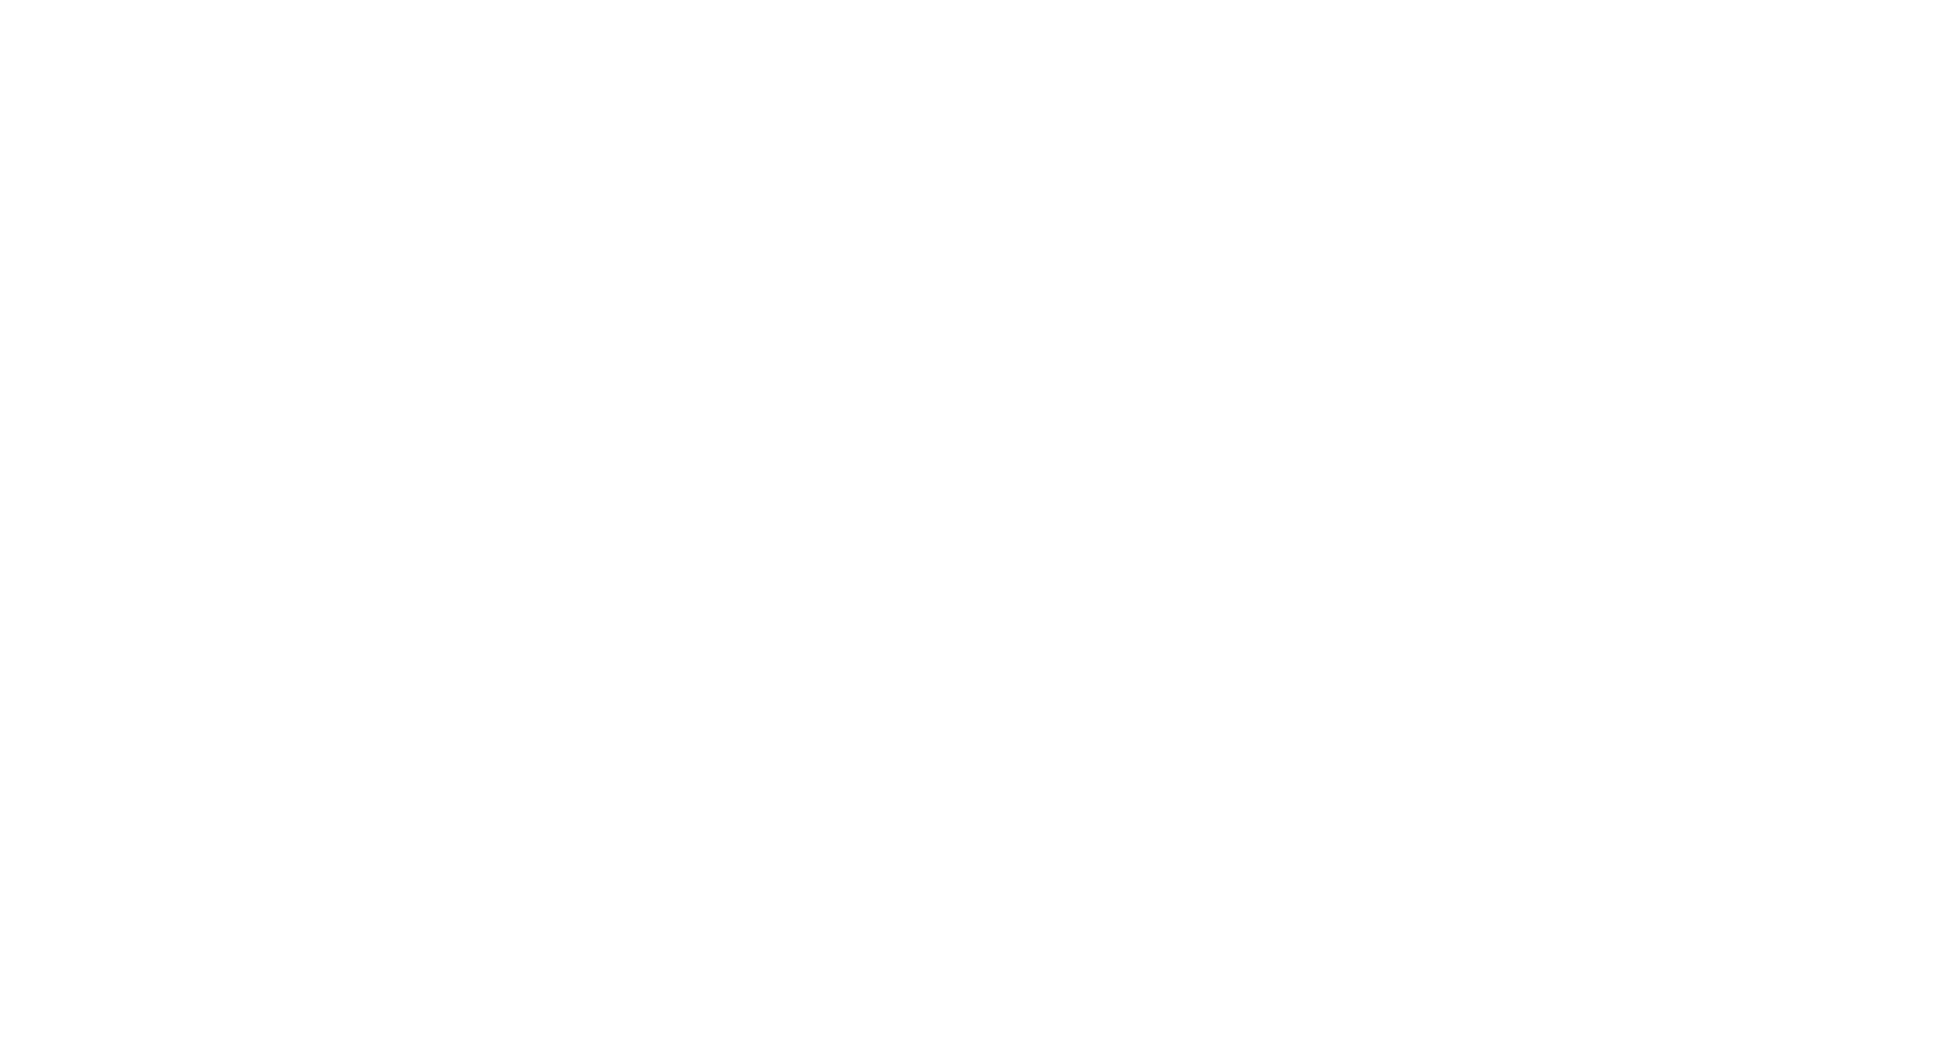

In [22]:
### THREE SIGMA

# Only take pixels above 3 sigma (order here is important! doy.)
sma_mass3sig = np.copy(sma_mass)
sma_column3sig = np.copy(sma_column)
sma_mass3sig[sma_column <= (3.*sma_noise_column)]=float('NaN')
sma_column3sig[sma_column <= (3.*sma_noise_column)]=float('NaN') 

# Write to files for further inspection
fits.writeto(path+'dense_gas_fraction/SMA_Msun_per_pix_3sigma.fits', data=sma_mass3sig, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_NH2_per_pix_3sigma.fits', data=sma_column3sig, header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_Msun_Herschel_Msun_per_pix_3sigma.fits', data=sma_mass3sig/mass_herschel, 
            header=cmzoomhdr, overwrite=True)
fits.writeto(path+'dense_gas_fraction/SMA_noise_NH2_pix.fits', data=sma_noise_column, 
            header=cmzoomhdr, overwrite=True)

#### CALCULATING

# SMA Mass Percent = smp ==> Percentage of SMA mass above this column density / Herschel Mass 
# smpsma ==> Percentage of SMA mass above this column density / Total SMA Mass
# sma_herschel ==> Percentage of total SMA mass / Total Herschel Mass
# Units of nh2 = 1e22 cm^-2, so smp5 = 5x10^22, smp50 = 5x10^23

# First get total SMA and Herschel masses for each cloud
mtot = np.zeros(nel)
sma_tot = np.zeros(nel)
for i in np.arange(0,nel):
    sma_tot[i] = np.nansum(sma_mass3sig[(mask==i+1)*(sma_column3sig > 0)]) # Be aware of this sma_column >0! we don't use this here.
    #mtot[i] = np.nansum(mass_herschel[(mask==i+1)*(sma_column > 0)]) #only where sma_column >0
    mtot[i] = np.nansum(mass_herschel[(mask==i+1)]) #everything in the mask

# Now, get the total SMA mass above each column density threshold
def getSMP(sma_column, mass_herschel, sma_mass, factor):
    smp = np.zeros(nel)
    smacloudmass = np.zeros(nel)
    smpsma = np.zeros(nel)
    sma_herschel = np.copy(mask)
    sma_herschel=0.0*sma_herschel
    for i in np.arange(0,nel):
        smacloudmass[i] = np.nansum(sma_mass[(mask==i+1)*(sma_column >= factor*1e22)])
        smp[i] = (smacloudmass[i]/mtot[i])
        smpsma[i] = (smacloudmass[i]/sma_tot[i])
        sma_herschel[mask==i+1] = (sma_tot[i]/mtot[i])
    return smp, smpsma, sma_herschel, smacloudmass, mtot

smp1_3sig, smpsma1_3sig, sma_herschel_3sig, smacloudmass1_3sig, mtot1 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 1.0)
smp5_3sig, smpsma5_3sig, sma_herschel_3sig, smacloudmass5_3sig, mtot5 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 5.0)
smp7_3sig, smpsma7_3sig, sma_herschel_3sig, smacloudmass7_3sig, mtot7 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 7.0)
smp10_3sig, smpsma10_3sig, sma_herschel_3sig, smacloudmass10_3sig, mtot10 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 10.0)
smp50_3sig, smpsma50_3sig, sma_herschel_3sig, smacloudmass50_3sig, mtot50 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 50.0)
smp100_3sig, smpsma100_3sig, sma_herschel_3sig, smacloudmass100_3sig, mtot100 = getSMP(sma_column3sig, mass_herschel, sma_mass3sig, 100.0)


#### PLOTTING

# Plot the column density fractions of SMA mass / Herschel mass as a BAR Graph
# With Cloud name instead of number
%matplotlib nbagg

plt.style.use('classic')
#plt.style.use('seaborn-colorblind')
#plt.style.use('battersbot-colorblind')

num_colors = 6
cm = plt.cm.get_cmap(name='viridis')
currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]

plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(11,6))
ax = fig.gca()
ax.set_yscale('log')

N = nel # number of masks
ind = np.arange(N)
width = 1

plt.bar(ind, smp1_3sig, width, color=currentColors[0])
plt.bar(ind, smp5_3sig, width, color=currentColors[1])
plt.bar(ind, smp7_3sig, width, color=currentColors[2])
plt.bar(ind, smp10_3sig, width, color=currentColors[3])
plt.bar(ind, smp50_3sig, width, color=currentColors[4])
plt.bar(ind,smp100_3sig, width, color=currentColors[5])

x=ind
my_xticks = ['1 - 1.6$^{\circ}$','2 - 1.6$^{\circ}$','3 - 1.6$^{\circ}$','4 - 1.6$^{\circ}$',
             '5 - 1.1$^{\circ}$','6 - 1.1$^{\circ}$','7 - 1.1$^{\circ}$','8 - SgrB2ext', '9 - SgrB2', '10 - SgrB2NW',
             '11 - DR e/f','12 - DR d','13 - HMSFR','14 - DR c','15 - DR b',
             '16 - FSC','17 - HMSFR','18 - Brick','19 - HMSFR',
             '20 - Straw','21 - Sticks','22 - Bridge','23 - Stone','24 - Arches w1','25 - Arches e1',
             '26 - 50km/s','27 - CND','28 - 20km/s','29 - FSC','30 - FSC',
             '31 - stream','32 - FSC','33 - HMSFR','34 - SgrC diffuse','35 - HMSFR', '36 - SgrC dense']
plt.xticks(x, my_xticks, fontsize=10, rotation='vertical', ha='left')

#plt.ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Mass}}{\rm{Total\ Herschel\ Mass}}$')
plt.ylabel(r'Method 2 CDGF = $\frac{\rm{SMA\ Mass}}{\rm{Total\ Herschel\ Mass}}$')
plt.xlabel(r'Cloud Name')
ax.set_ylim([0.0006,1])
ax.set_xlim([0,nel])
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis

plt.legend(['SMA Mass > 1 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 5 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 7 x $10^{22}$ cm$^{-2}$',
            'SMA Mass > 1 x $10^{23}$ cm$^{-2}$',  
            'SMA Mass > 5 x $10^{23}$ cm$^{-2}$', 
            'SMA Mass > 1 x $10^{24}$ cm$^{-2}$'],
            loc='upper left', fontsize=10, ncol=3)

plt.text(0.5, 0.25, 'All pixels above 3 $\sigma$', color='black')
plt.savefig(pathfig+'CMZoom_sma_mass_vs_herschel_fraction_bar_3sigmacut.pdf',
            format='pdf', dpi=500, bbox_inches='tight')


In [23]:
# Make dgf ratios for 2 and 3 sigma cuts and for CMZ and "non CMZ" clouds and "not sure if in CMZ" clouds
# Include complementary data
#noncloud_numbers = [2, 13, 17, 19, 33, 35] #arg -1 for indexing...?
noncloud_numbers = [1, 12, 16, 18, 32, 34]

#definitely not in CMZ = [17, 33]
noncloud_numbers=[16,32]

#not sure if in CMZ = [35, 19, 13, 2]
notsure_numbers=[34, 18, 12, 1] # this includes G1.67
#notsure_numbers=[34, 18, 12] # this does not include G1.67

# Clouds that are not in CMZ
# Method 1
ratio2sig_non = S_flux2sig[noncloud_numbers]/B_flux2sig[noncloud_numbers]
ratio3sig_non = S_flux3sig[noncloud_numbers]/B_flux3sig[noncloud_numbers]
#Herschel
Hnh2med_non = Hnh2med[noncloud_numbers]
#Method 2
smp1_3sig_non = smp1_3sig[noncloud_numbers]

# W51, 1.0e23, method 1 DGF: 0.30, Ginsburg et al. 
Hnh2med_w51 = 1.0e23
dgf1_w51 = np.array([0.30])

# IRDCs from Ash:
# Import IRDC numbers from Ash:
from astropy.table import Table
table = Table.read('/Users/battersby/Dropbox/CMZoom_Data/dense_gas_fraction/dgf_comparison/fdense_clouds.fits')
#print(table.colnames) #to show column names
Hnh2med_irdcs = table['Nh2'].quantity
#t['a'].quantity
ratio_irdcs = table['fdense'].to('') #to get into unitless units (i.e. not percent)
#print(Hnh2med_irdcs, ratio_irdcs)

# Filamentary clouds from Walker (email Feb. 28, 2020): 
# https://ui.adsabs.harvard.edu/abs/2018ApJ...855....9L/abstract
#Hnh2med_filaments = np.array([1.23e22, 0.89e22, 1.34e22, 1.39e22, 1.10e22, 1.15e22, 0.90e22])
#ratio_filaments = np.array([0.34, 0.22, 0.29, 0.26, 0.22, 0.30, 0.35])
# Update Feb 28, 2020
#Targets                           I18308    I18310   I18337   I18460   I18530   I19074   I19220
#SMA flux (Jy)                 0.85        0.54       0.89       0.24       0.91       0.28       0.51
#MAMBO flux (Jy)           2.62        2.65       3.20       1.01       4.60       1.07       1.54
#Ratio                              0.33        0.21       0.28       0.24       0.20       0.27       0.33
#Median N (1e22 cm-2)  1.52        1.28        1.86      1.74       1.36       1.39        1.41
Hnh2med_filaments = np.array([1.52e22, 1.28e22, 1.86e22, 1.74e22, 1.36e22, 1.39e22, 1.41e22])
ratio_filaments = np.array([0.33, 0.21, 0.28, 0.24, 0.20, 0.27, 0.33])


#Clouds that we are not sure if they are in the CMZ or not!
#Method 1
ratio2sig_not = S_flux2sig[notsure_numbers]/B_flux2sig[notsure_numbers]
ratio3sig_not = S_flux3sig[notsure_numbers]/B_flux3sig[notsure_numbers]
#Herschel
Hnh2med_not = Hnh2med[notsure_numbers]
#Method 2
smp1_3sig_not = smp1_3sig[notsure_numbers]


#CMZ clouds (all the rest)
allcloud_numbers = np.arange(0,nel,1)
#not sure why below doesn't work, but split into two lines it does :(
#cmzcloud_numbers = [i for i in allcloud_numbers if i not in noncloud_numbers or notsure_numbers]
v1 = [i for i in allcloud_numbers if i not in notsure_numbers]
cnd = [26] #mask 27 so index is 26
v2 = [i for i in v1 if i not in cnd]
cmzcloud_numbers = [i for i in v2 if i not in noncloud_numbers]

#Method 1
ratio2sig_cmz = S_flux2sig[cmzcloud_numbers]/B_flux2sig[cmzcloud_numbers]
ratio3sig_cmz = S_flux3sig[cmzcloud_numbers]/B_flux3sig[cmzcloud_numbers]
#Herschel
Hnh2med_cmz = Hnh2med[cmzcloud_numbers]
#Method 2
smp1_3sig_cmz = smp1_3sig[cmzcloud_numbers]

# Method 1 all non CMZ points in one array
ratio1_noncmz = np.concatenate((ratio3sig_non, ratio_filaments, dgf1_w51))

#Method 2 all non CMZ points in one array
ratio2_noncmz = np.concatenate((smp1_3sig_non, ratio_irdcs))


<IPython.core.display.Javascript object>


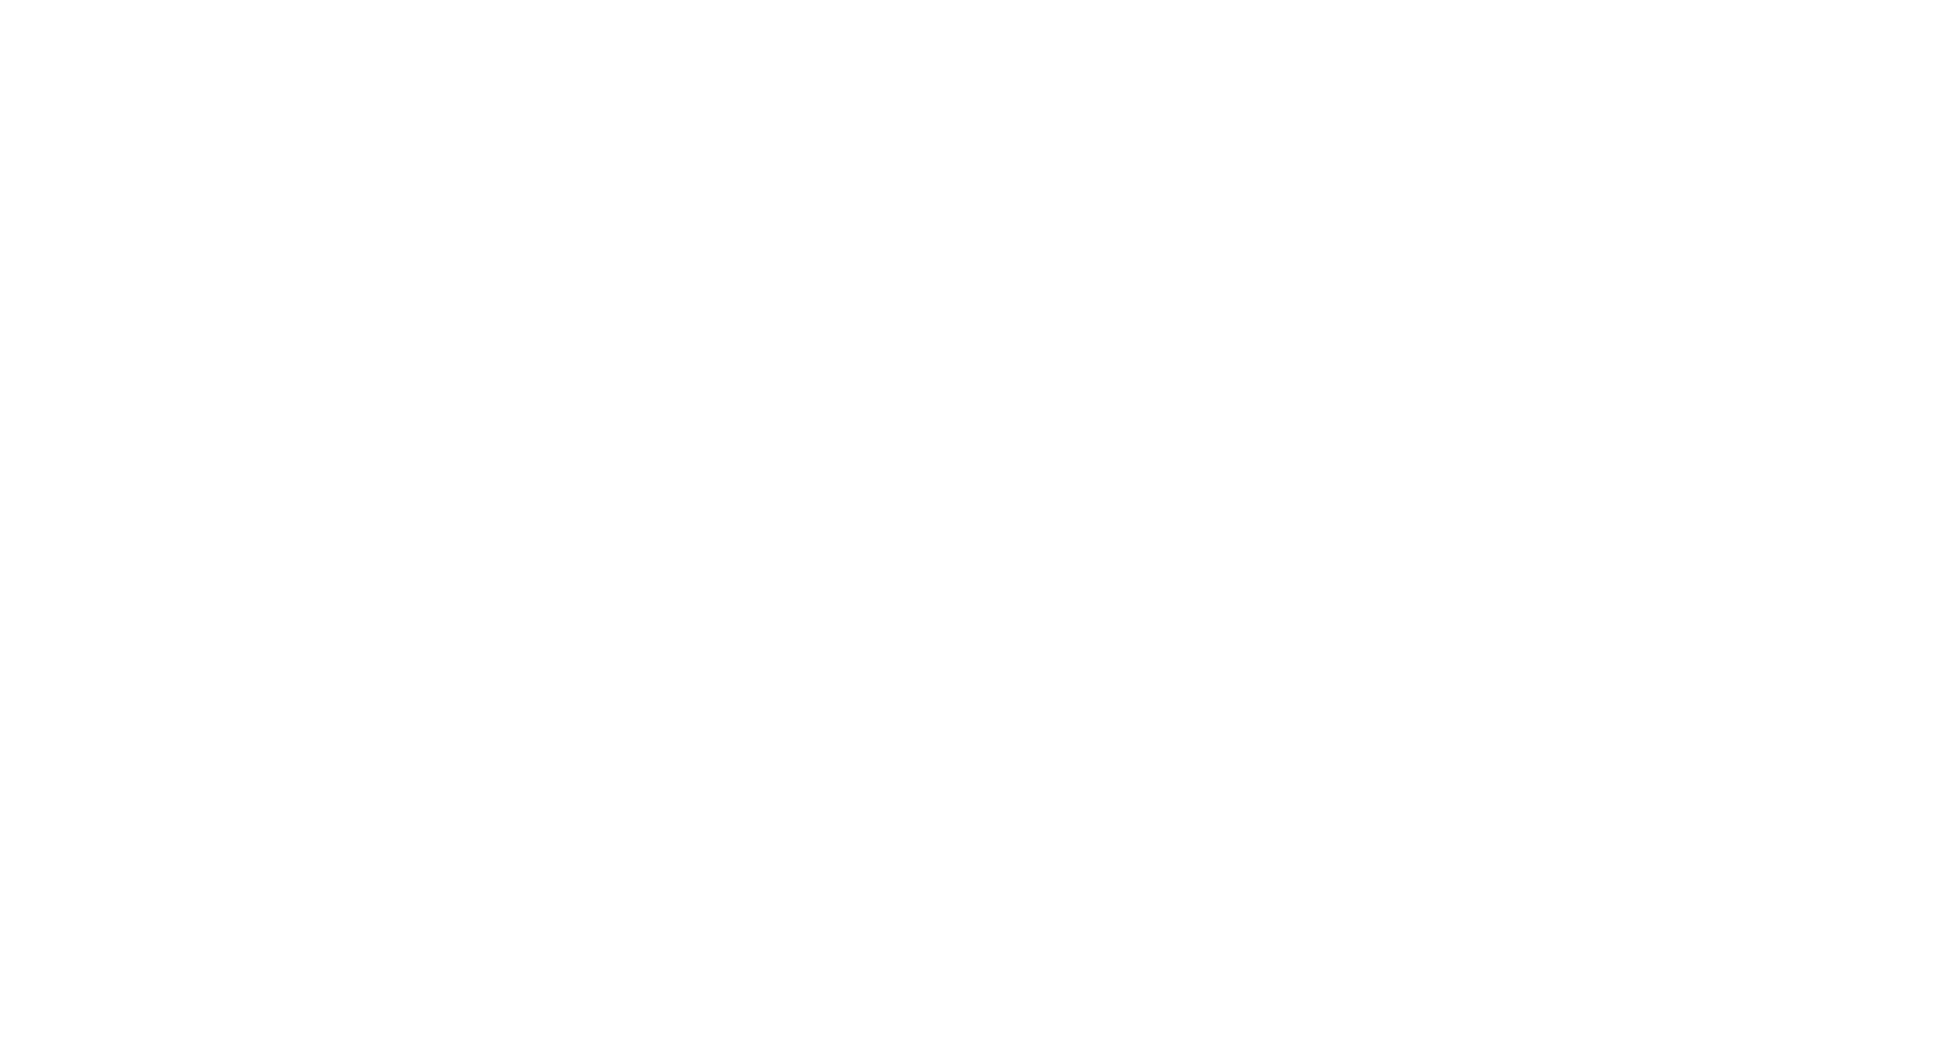

In [24]:
#METHOD 1 (method 2 below)
# Plot DGF vs. N(H2) for all clouds, separated by CMZ and non-CMZ
# also, include a few (or one?) other region
%matplotlib nbagg

#plt.style.use('battersbot-colorblind')
plt.style.use('seaborn-colorblind')
#plt.style.use('classic')
#plt.style.use('fivethirtyeight')

plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(11,6))
ax = fig.gca()
ax.set_xscale('log')

plt.plot(Hnh2med_cmz, ratio3sig_cmz, 'D', alpha=1, label=r'CMZ', color = 'blue')
plt.plot(Hnh2med_not, ratio3sig_not, 's', alpha=1, label=r'Not sure if in CMZ', color='cyan')
plt.plot(Hnh2med_non, ratio3sig_non, 'o', alpha=1, label=r'Non-CMZ CMZoom', color='red')
plt.plot(Hnh2med_filaments, ratio_filaments, 'P', alpha=1, label=r'Non-CMZ filaments', color='red') # non-CMZ


#single point plot
plt.plot(1e23,0.30, 'x', color='red', label=r'Non-CMZ W51')
plt.plot([5e22,2e23],[0.3,0.3], color='red')
plt.plot([1e23,1e23],[0.27,0.33], color='red')#, label='W51') # Ginsburg et al. (2016) quoted error
plt.plot([1e23,1e23],[0.15,0.6], color='red')#, label='W51') # factor of 2 error (since ALMA)


#Label individual points in CMZ
plt.text(3e23, 0.5, 'SgrB2', color='blue', fontsize=12)
plt.text(5.5e22, 0.32, 'DR C', color='blue', fontsize=12)
#plt.text(3.5e22, 0.45, 'CND', color='blue', fontsize=12)
plt.text(7.5e22, 0.11, 'SgrC', color='blue', fontsize=12)
plt.text(1.1e23, 0.052, '20 km/s', color='blue', fontsize=12)

# Label ones we are not sure if they are CMZ or not
plt.text(1.5e22, 0.7, 'G359.137', color='cyan', fontsize=12)
plt.text(4.2e22, 0.2, 'G0.212', color='cyan', fontsize=12)
plt.text(2e22, 0.31, 'G0.393', color='cyan', fontsize=12)
plt.text(6.5e22, 0.4, 'G1.670', color='cyan', fontsize=12)

# Definitely NOT CMZ
plt.text(0.94e23, 0.23, 'W51', color='red', fontsize=12)
plt.text(5.7e22, 0.19, 'G359.615', color='red', fontsize=12)
plt.text(3e22, 0.3, 'G0.316', color='red', fontsize=12)

# Add more x tick labels
ax.set_xticks([1e22, 2e22, 4e22, 6e22, 1e23, 2e23, 4e23])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Flux}}{\rm{BGPS\ Flux}}$')
plt.xlabel(r'Median Herschel N(H$_2$) [cm$^{-2}$]')
ax.set_ylim([0.01,1])
#ax.set_xlim([1.5e22, 5e23])
ax.set_xlim([7e21, 5e23])
ax.set_yscale('log')
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis

legend = plt.legend(loc='lower left', shadow=False, fontsize=14, frameon=True, numpoints=1)#'x-large')
legend.get_frame().set_facecolor('white')

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_dgf_sma_over_bgps_cmz_disk.pdf',
            format='pdf', dpi=500, bbox_inches='tight')




<IPython.core.display.Javascript object>


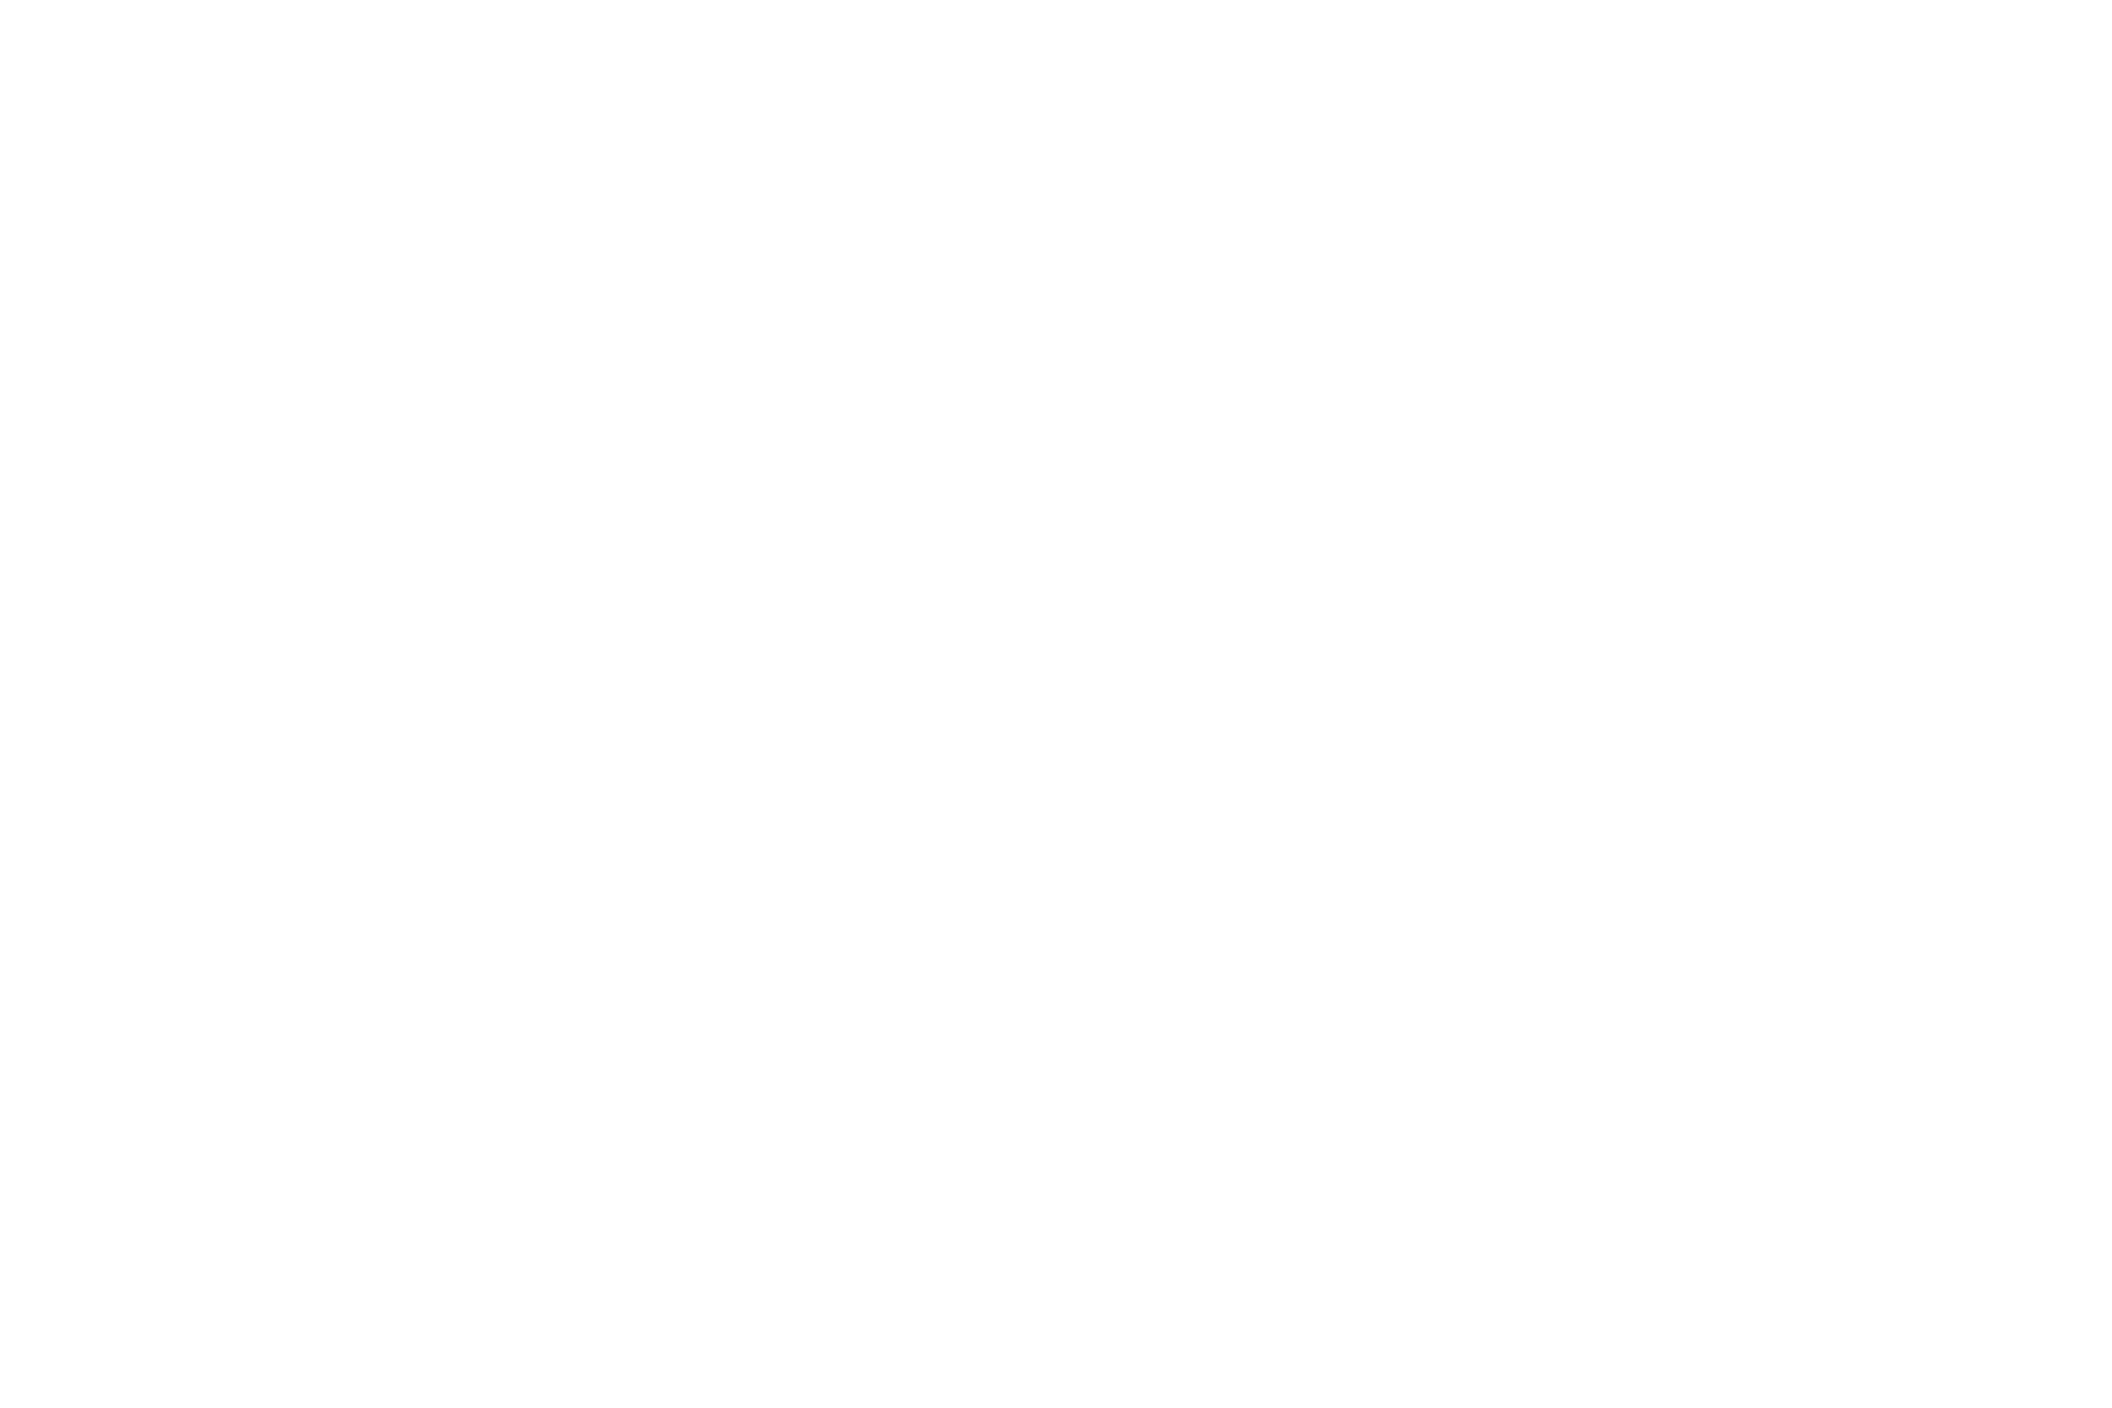

In [25]:
# METHOD 1 with HISTOGRAM
# Adapted from: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html
# Plot DGF vs. N(H2) for all clouds, separated by CMZ and non-CMZ
# also, include a few (or one?) other region
%matplotlib nbagg

plt.style.use('seaborn-colorblind')
fontsize=14
alpha=1
markersize=26

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1, figsize=(12, 8))

ax_scatter = plt.axes(rect_scatter)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(Hnh2med_cmz/1e22, ratio3sig_cmz, s=markersize,marker='D', alpha=1, label=r'CMZ', color = 'blue')
ax_scatter.scatter(Hnh2med_not/1e22, ratio3sig_not, s=markersize,marker='s', alpha=1, label=r'Not sure if in CMZ', color='cyan')
ax_scatter.scatter(Hnh2med_non/1e22, ratio3sig_non, s=markersize,marker='o', alpha=1, label=r'Non-CMZ CMZoom', color='red')
ax_scatter.scatter(Hnh2med_filaments/1e22, ratio_filaments, s=markersize,marker='P', alpha=1, label=r'Non-CMZ filaments', color='red') # non-CMZ

#single point plot for W51
ax_scatter.scatter(10,0.30, s=markersize, marker='x', color='red', label=r'Non-CMZ W51')
#ax_scatter.scatter([5,20],[0.3,0.3], color='red')
#ax_scatter.scatter([10,10],[0.27,0.33], color='red')#, label='W51') # Ginsburg et al. (2016) quoted error
#ax_scatter.scatter([10,10],[0.15,0.6], color='red')#, label='W51') # factor of 2 error (since ALMA)

# Labels and limits
ax_scatter.set_xlim([0.8, 50]) # divided by 1e22
#ax_scatter.set_ylim((0.0005,1))
ax_scatter.set_ylim((0.01,1))
ax_scatter.set_ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Flux}}{\rm{BGPS\ Flux}}$')
ax_scatter.set_xlabel(r'Median Herschel N(H$_2$) [$\times 10^{22}$ cm$^{-2}$]')
ax_histy.set_xlabel(r'Number')
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')

# Add more x tick labels
ax_scatter.set_xticks([1, 2, 4, 6, 10, 20, 40])
ax_scatter.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


#Make bins
#CMZ
bins = np.logspace(np.log(5e-4), np.log(1), num=50)
ax_histy.hist(ratio3sig_cmz, bins=bins, orientation='horizontal', color='blue', alpha=0.5)
#non CMZ
ax_histy.hist(ratio1_noncmz, bins=bins, orientation='horizontal', color='red', alpha=0.5)
ax_histy.set_yscale('log')

ax_histy.set_ylim(ax_scatter.get_ylim())

#Label individual points in CMZ
ax_scatter.text(30, 0.5, 'SgrB2', color='blue', fontsize=12)
ax_scatter.text(5.5, 0.32, 'DR C', color='blue', fontsize=12)
#ax_scatter.text(3.5, 0.45, 'CND', color='blue', fontsize=12)
ax_scatter.text(7.5, 0.11, 'SgrC', color='blue', fontsize=12)
ax_scatter.text(11, 0.052, '20 km/s', color='blue', fontsize=12)

# Label ones we are not sure if they are CMZ or not
ax_scatter.text(1.5, 0.7, 'G359.137', color='cyan', fontsize=12)
ax_scatter.text(4.2, 0.2, 'G0.212', color='cyan', fontsize=12)
ax_scatter.text(2, 0.31, 'G0.393', color='cyan', fontsize=12)
ax_scatter.text(6.5, 0.4, 'G1.670', color='cyan', fontsize=12)

# Definitely NOT CMZ
ax_scatter.text(9.4, 0.23, 'W51', color='red', fontsize=12)
ax_scatter.text(5.7, 0.19, 'G359.615', color='red', fontsize=12)
ax_scatter.text(3, 0.3, 'G0.316', color='red', fontsize=12)



ax_scatter.legend(loc='lower left', shadow=False, fontsize=16, frameon=True, scatterpoints=1)

plt.show()

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_dgf_sma_over_bgps_cmz_disk_histogram.pdf',
            format='pdf', dpi=500, bbox_inches='tight')




<IPython.core.display.Javascript object>


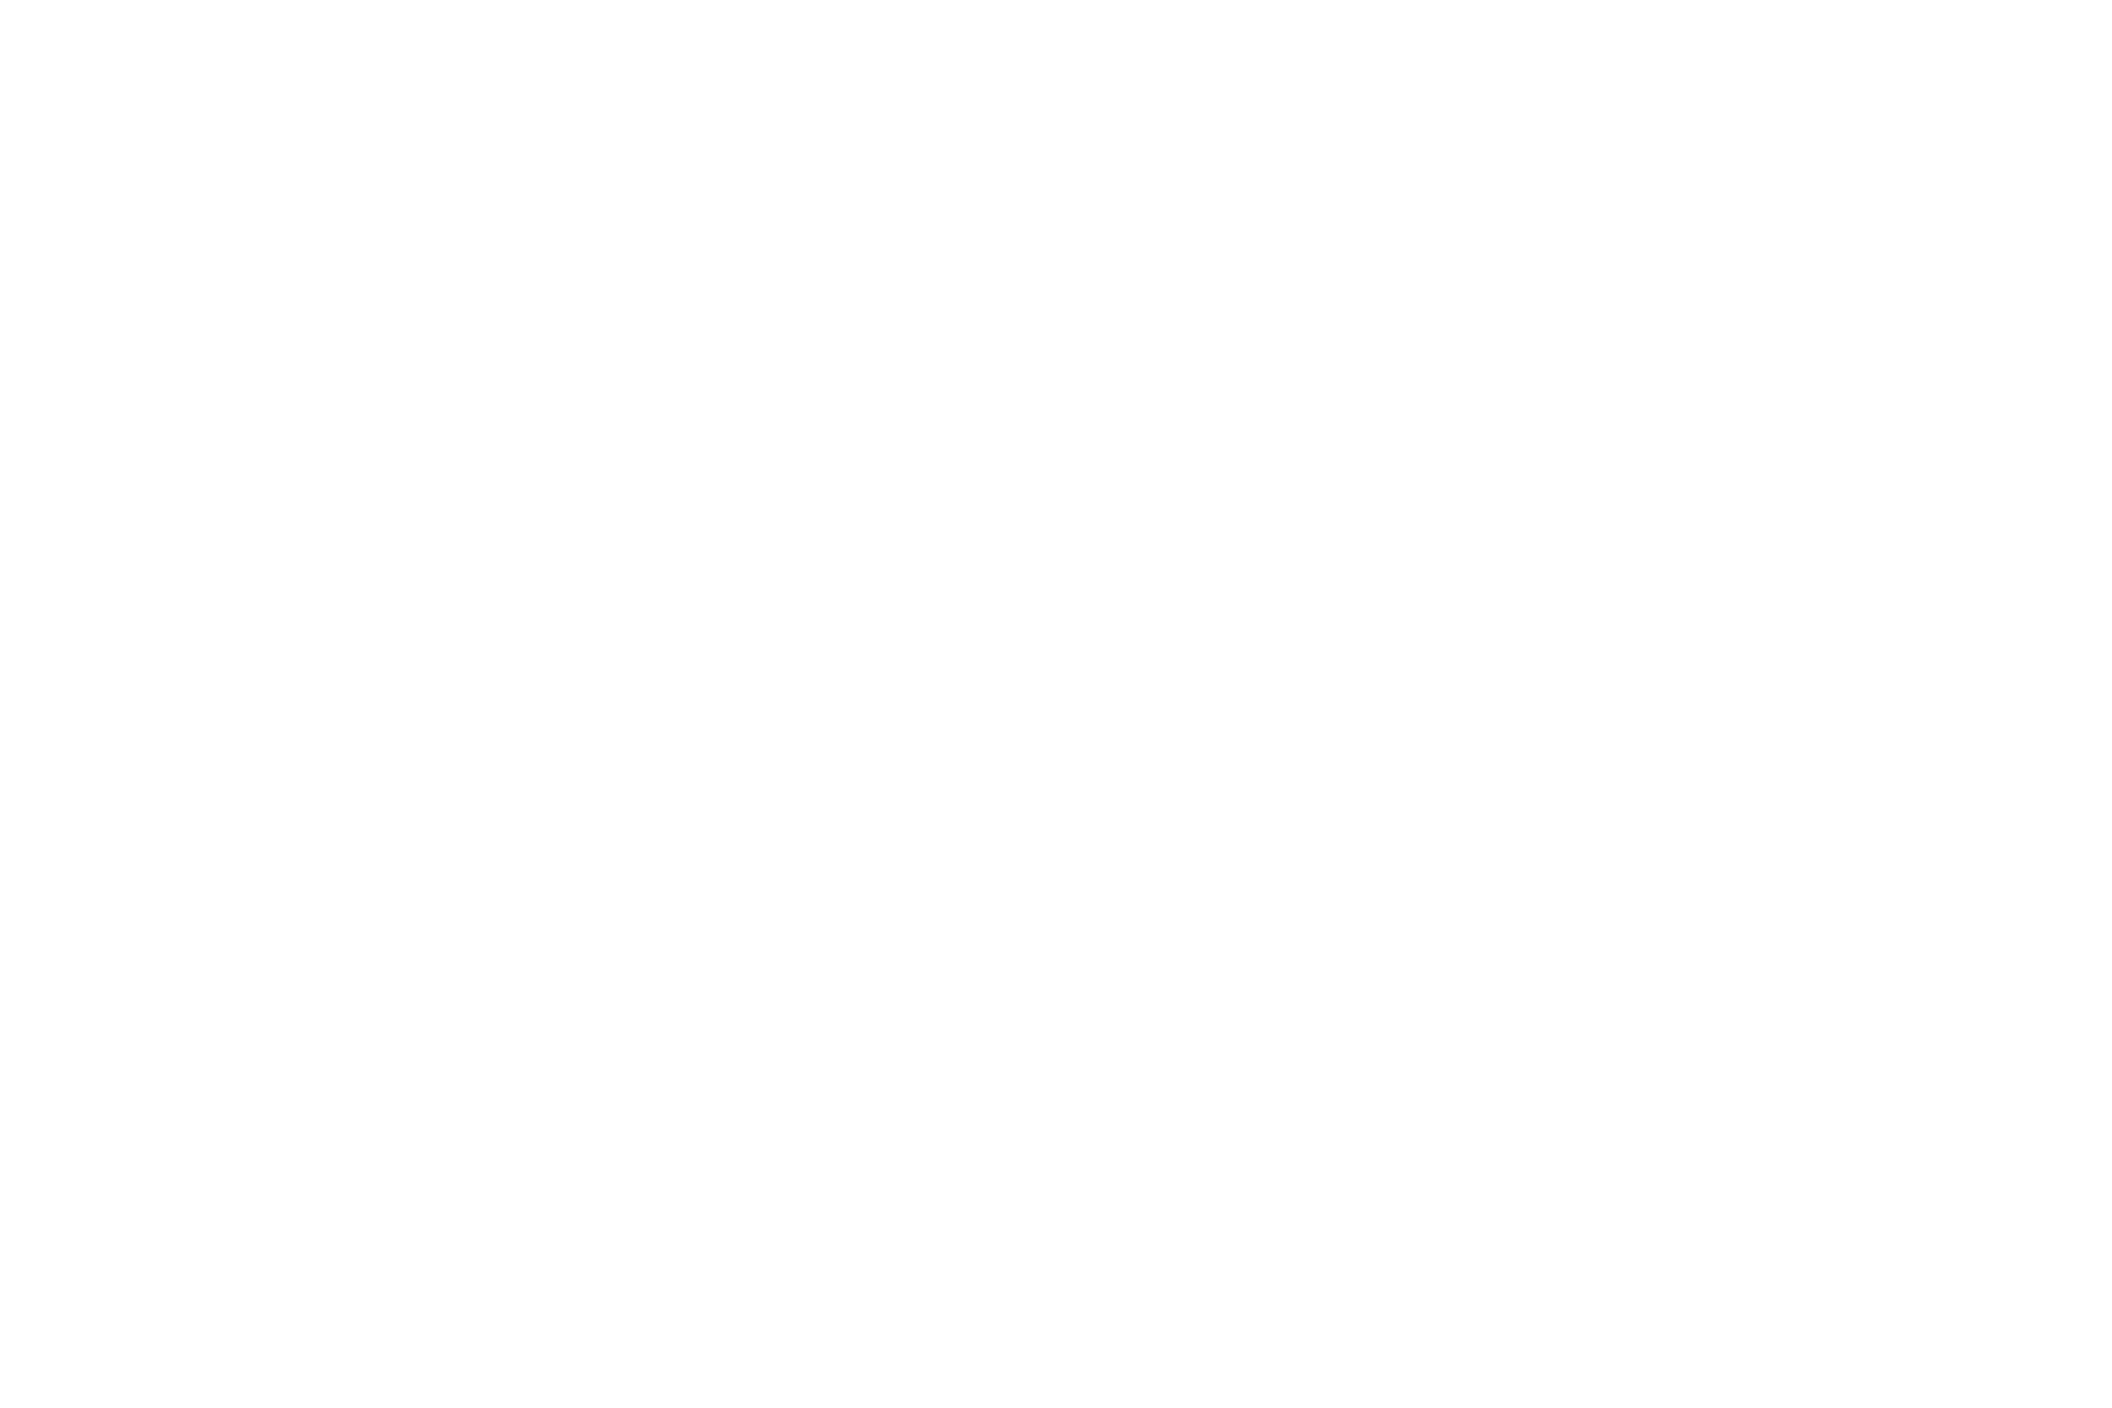

/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':


In [26]:
# METHOD 1 with HISTOGRAM and KDE
%matplotlib nbagg

plt.style.use('seaborn-colorblind')
fontsize=14
markersize=60

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005
alpha=0.5
linewidth=3

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1, figsize=(12, 8))

ax_scatter = plt.axes(rect_scatter)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(Hnh2med_cmz/1e22, ratio3sig_cmz, s=markersize,marker='D', alpha=alpha, label=r'CMZ', color = 'blue')
ax_scatter.scatter(Hnh2med_not/1e22, ratio3sig_not, s=markersize,marker='s', alpha=alpha, label=r'Not sure if in CMZ', color='cyan')
ax_scatter.scatter(Hnh2med_non/1e22, ratio3sig_non, s=markersize,marker='o', alpha=alpha, label=r'Non-CMZ CMZoom', color='red')
ax_scatter.scatter(Hnh2med_filaments/1e22, ratio_filaments, s=markersize,marker='P', alpha=alpha, label=r'Non-CMZ filaments', color='red') # non-CMZ

#single point plot for W51
ax_scatter.scatter(10,0.30, s=markersize, marker='x', color='red', label=r'Non-CMZ W51')
#ax_scatter.scatter([5,20],[0.3,0.3], color='red')
#ax_scatter.scatter([10,10],[0.27,0.33], color='red')#, label='W51') # Ginsburg et al. (2016) quoted error
#ax_scatter.scatter([10,10],[0.15,0.6], color='red')#, label='W51') # factor of 2 error (since ALMA)

# Labels and limits
#ax_scatter.set_xlim([0.8, 50]) # divided by 1e22
ax_scatter.set_xlim([1.2, 50]) # divided by 1e22 -- changed so that method 1 and 2 x axis match
ax_scatter.set_ylim((0.003,1))
#ax_scatter.set_ylim((0.01,1))
#ax_scatter.set_ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Flux}}{\rm{BGPS\ Flux}}$')
ax_scatter.set_ylabel(r'Method 1 CDGF = $\frac{\rm{SMA\ Flux}}{\rm{BGPS\ Flux}}$')
ax_scatter.set_xlabel(r'Median Herschel N(H$_2$) [$\times 10^{22}$ cm$^{-2}$]')
#ax_histy.set_xlabel(r'Number')
ax_histy.set_xlabel(r'Normalized Number')
ax_histy.xaxis.set_ticks(np.arange(0, 1.5, 0.5))
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')

# Add more x tick labels
ax_scatter.set_xticks([2, 4, 6, 10, 20, 40])
ax_scatter.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#### CMZ
# Histogram
data = ratio3sig_cmz
bins = np.logspace(np.log(5e-4), np.log(1), num=50)
_, bin_cent1, hist1 = histograms.get_hist(data, bins=bins, norm=True)
ax_histy.fill_between(hist1, 0, bin_cent1, color='blue', alpha=alpha, step='pre') # To fill the histogram
#ax_histy.plot(hist1, bin_cent1, color='blue', ds='steps', alpha=alpha) # To outline the histogram
# KDE
offset = 4
data_log = np.log10(data)+offset
#POINT 1
bins2 = np.linspace(0, 4, 100)
_, bin_cent2_log, hist2 = histograms.get_histkde(data_log, norm=True, bins=bins2)
bin_cent2 = 10**(bin_cent2_log-offset)
ax_histy.plot(hist2, bin_cent2, color='blue', alpha=alpha, linewidth=linewidth) # To outline the KDE
#ax_histy.fill_between(hist2, 0, bin_cent2, color='red', alpha=0.5, step='mid') # To fill the KDE

#### NON CMZ
#non CMZ
data=ratio1_noncmz
bins = np.logspace(np.log(5e-4), np.log(1), num=50)
_, bin_cent1, hist1 = histograms.get_hist(data, bins=bins, norm=True)
ax_histy.fill_between(hist1, 0, bin_cent1, color='red', alpha=alpha, step='pre') # To fill the histogram
#ax_histy.plot(hist1, bin_cent1, color='red', ds='steps', alpha=alpha) # To outline the histogram
# KDE
offset = 4
data_log = np.log10(data)+offset
#POINT 2
bins2 = np.linspace(0, 4, 100)
_, bin_cent2_log, hist2 = histograms.get_histkde(data_log, norm=True, bins=bins2)
bin_cent2 = 10**(bin_cent2_log-offset)
ax_histy.plot(hist2, bin_cent2, color='red', alpha=alpha, linewidth=linewidth) # To outline the KDE
#ax_histy.fill_between(hist2, 0, bin_cent2, color='red', alpha=0.5, step='mid') # To fill the KDE


# Set histogram axes
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim([-0.1, 1.1])


#Label individual points in CMZ
ax_scatter.text(30, 0.45, 'SgrB2', color='blue', fontsize=12)
ax_scatter.text(5.5, 0.32, 'DR C', color='blue', fontsize=12)
#ax_scatter.text(3.5, 0.45, 'CND', color='blue', fontsize=12)
#ax_scatter.text(7.5, 0.11, 'SgrC - overall', color='blue', fontsize=12)
ax_scatter.text(8.2, 0.00365, 'SgrC - diffuse', color='blue', fontsize=12)
ax_scatter.text(11.5, 0.27, 'SgrC - dense', color='blue', fontsize=12)
#ax_scatter.text(11, 0.052, '20 km/s', color='blue', fontsize=12) # too crowded to see and appreciate!

# Label ones we are not sure if they are CMZ or not
ax_scatter.text(1.5, 0.7, 'G359.137', color='cyan', fontsize=12)
ax_scatter.text(4.0, 0.155, 'G0.212', color='cyan', fontsize=12)
ax_scatter.text(2, 0.31, 'G0.393', color='cyan', fontsize=12)
#ax_scatter.text(6.5, 0.4, 'G1.670', color='cyan', fontsize=12)
ax_scatter.text(6.5, 0.19, 'G1.670', color='cyan', fontsize=12)

# Definitely NOT CMZ
ax_scatter.text(9.1, 0.32, 'W51', color='red', fontsize=12)
ax_scatter.text(3.9, 0.23, 'G359.615', color='red', fontsize=12)
ax_scatter.text(3, 0.3, 'G0.316', color='red', fontsize=12)

ax_scatter.legend(loc='lower left', shadow=False, fontsize=16, frameon=True, scatterpoints=1)

plt.show()

plt.savefig(pathfig+'CMZoom_dgf_sma_over_bgps_cmz_disk_histogram_kde.pdf',
            format='pdf', dpi=500, bbox_inches='tight')




<IPython.core.display.Javascript object>


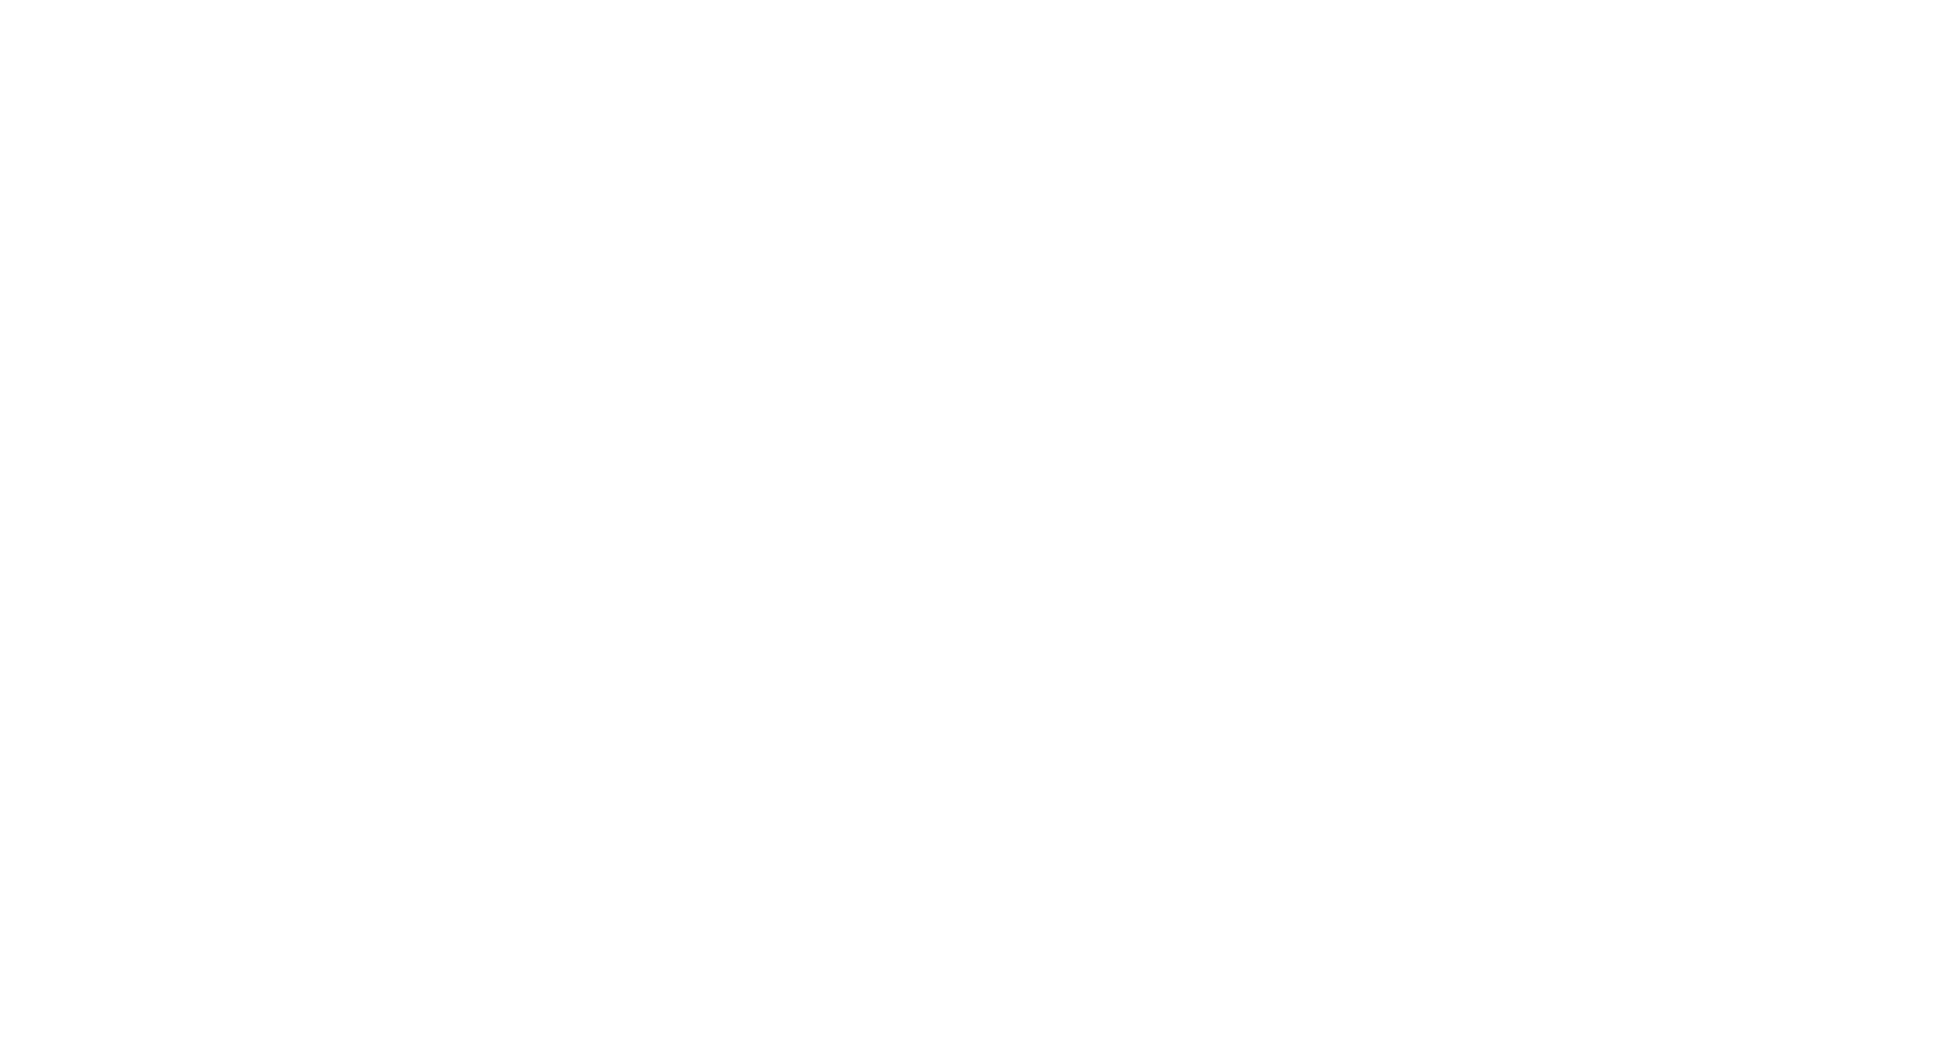

In [27]:
# METHOD 2
# Plot DGF vs. N(H2) for all clouds, separated by CMZ and non-CMZ
# also, include a few (or one?) other region
%matplotlib nbagg

#plt.style.use('battersbot-colorblind')
plt.style.use('seaborn-colorblind')
#plt.style.use('classic')
#plt.style.use('fivethirtyeight')

plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1,figsize=(11,6))
ax = fig.gca()
ax.set_xscale('log')

plt.plot(Hnh2med_cmz, smp1_3sig_cmz, 'D', alpha=1, label=r'CMZ', color = 'blue')
plt.plot(Hnh2med_not, smp1_3sig_not, 's', alpha=1, label=r'Not sure if in CMZ', color='cyan')
plt.plot(Hnh2med_non, smp1_3sig_non, 'o', alpha=1, label=r'Non-CMZ CMZoom', color='red')
plt.plot(Hnh2med_irdcs, ratio_irdcs, 'P', alpha=1, label=r'Non-CMZ IRDCs', color='red') # non-CMZ


#single point plot
#plt.plot(3.6e23, 0.06, '.', color='red')
#plt.plot(1e23,0.30, 'o', color='red')
#plt.plot([5e22,2e23],[0.3,0.3], color='red')#, label='W51')
#plt.plot([1e23,1e23],[0.27,0.33], color='red')#, label='W51') # Ginsburg et al. (2016) quoted error
#plt.plot([1e23,1e23],[0.15,0.6], color='red')#, label='W51') # factor of 2 error (since ALMA)


#Label individual points in CMZ
plt.text(3.2e23, 0.07, 'SgrB2', color='blue', fontsize=12)
plt.text(5.3e22, 0.085, 'DR C', color='blue', fontsize=12)
plt.text(7.4e22, 0.028, 'SgrC', color='blue', fontsize=12)
plt.text(1.1e23, 0.02, '20 km/s', color='blue', fontsize=12)

# Label ones we are not sure if they are CMZ or not
plt.text(1.5e22, 0.2, 'G359.137', color='cyan', fontsize=12)
plt.text(4.2e22, 0.04, 'G0.212', color='cyan', fontsize=12)
plt.text(2.1e22, 0.008, 'G0.393', color='cyan', fontsize=12)
plt.text(6.5e22, 0.06, 'G1.670', color='cyan', fontsize=12)

# Definitely NOT CMZ
#plt.text(0.94e23, 0.23, 'W51', color='red', fontsize=12)
plt.text(5.4e22, 0.14, 'G359.615', color='red', fontsize=12)
plt.text(3e22, 0.20, 'G0.316', color='red', fontsize=12)

# Add more x tick labels
ax.set_xticks([2e22, 4e22, 6e22, 1e23, 2e23, 4e23])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Mass}}{\rm{Herschel\ Mass}}$')
plt.xlabel(r'Median Herschel N(H$_2$) [cm$^{-2}$]')
ax.set_ylim([0.0005,1])
ax.set_xlim([1.5e22, 5e23])
ax.set_yscale('log')
plt.gcf().subplots_adjust(bottom=0.15) # make room for x-axis

legend = plt.legend(loc='lower right', shadow=False, fontsize=14, frameon=True, numpoints=1)#'x-large')
legend.get_frame().set_facecolor('white')

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_dgf_sma_over_herschel_cmz_disk.pdf',
            format='pdf', dpi=500, bbox_inches='tight')




<IPython.core.display.Javascript object>


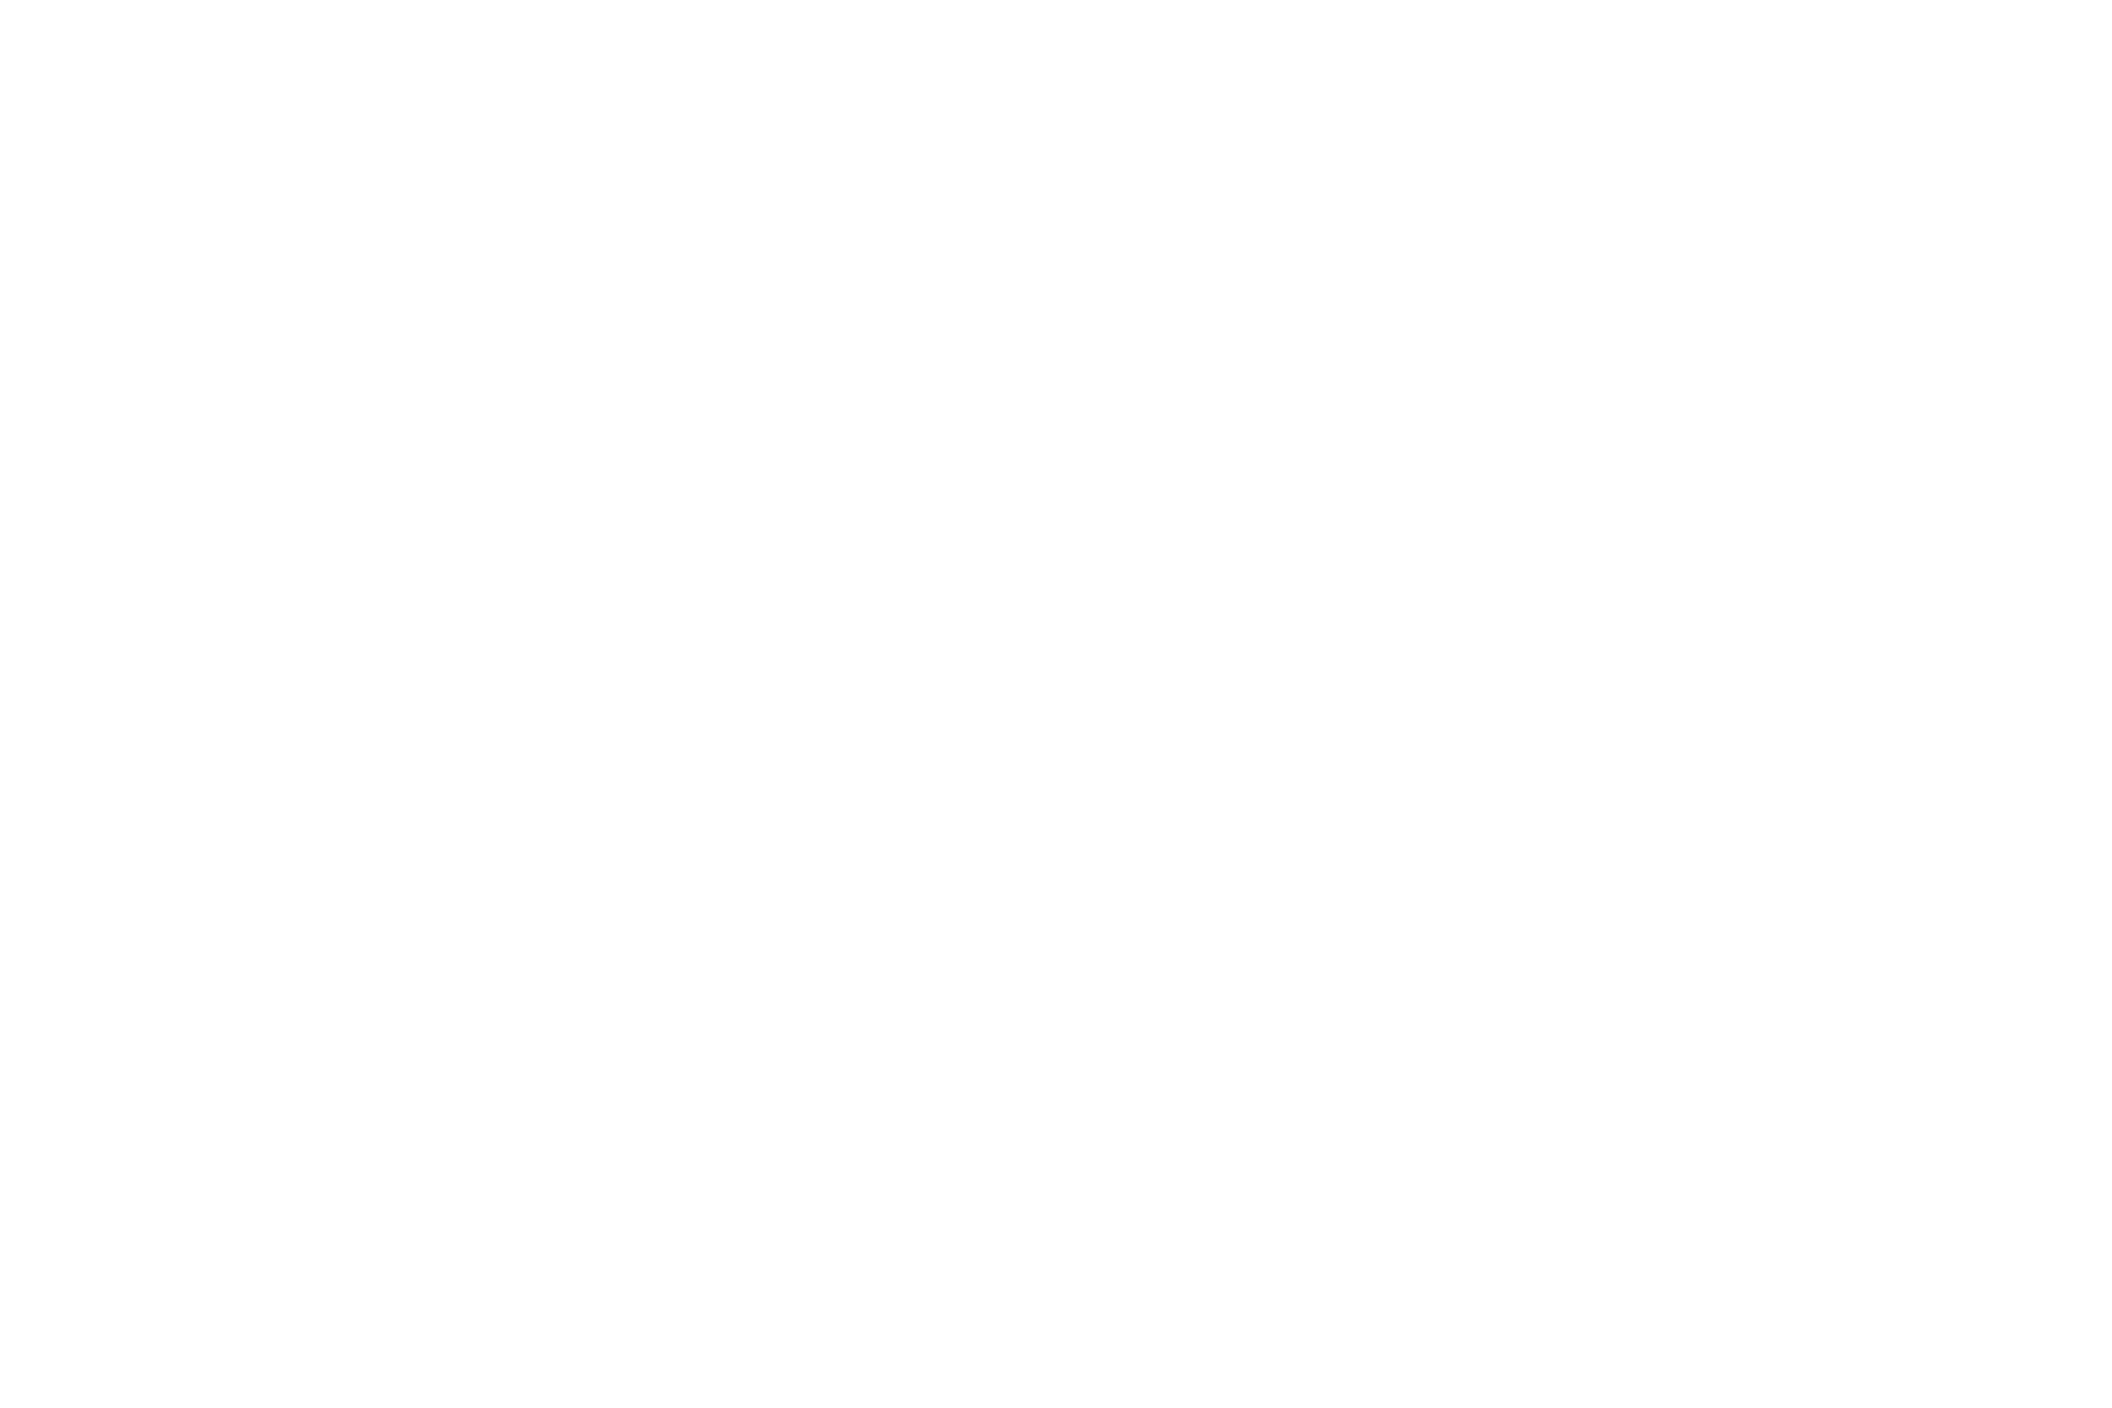

In [28]:
# METHOD 2 with HISTOGRAM
# Adapted from: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html
# Plot DGF vs. N(H2) for all clouds, separated by CMZ and non-CMZ
# also, include a few (or one?) other region
%matplotlib nbagg

plt.style.use('seaborn-colorblind')
fontsize=14
alpha=1
markersize=26

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1, figsize=(12, 8))

ax_scatter = plt.axes(rect_scatter)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
#x = Hnh2med_cmz/1e22
#y = smp1_3sig_cmz
ax_scatter.scatter(Hnh2med_cmz/1e22, smp1_3sig_cmz, s=markersize, marker='D', color='blue', alpha=alpha, label=r'CMZ')
ax_scatter.scatter(Hnh2med_not/1e22, smp1_3sig_not, s=markersize, marker='s', color='cyan', alpha=alpha, label=r'Not sure if in CMZ')
ax_scatter.scatter(Hnh2med_non/1e22, smp1_3sig_non, s=markersize, marker='o', color='red', alpha=alpha,label=r'Non-CMZ CMZoom')
ax_scatter.scatter(Hnh2med_irdcs/1e22, ratio_irdcs, s=markersize, marker='P', color='red', alpha=alpha,label=r'Non-CMZ IRDCs')

ax_scatter.set_xlim([1.5, 50]) # divided by 1e22
ax_scatter.set_ylim((0.0005,1))
ax_scatter.set_ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Mass}}{\rm{Herschel\ Mass}}$')
ax_scatter.set_xlabel(r'Median Herschel N(H$_2$) [$\times 10^{22}$ cm$^{-2}$]')
ax_histy.set_xlabel(r'Number')
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')

# Add more x tick labels
ax_scatter.set_xticks([2, 4, 6, 10, 20, 40])
ax_scatter.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#Make bins
#CMZ
bins = np.logspace(np.log(5e-4), np.log(1), num=50)
ax_histy.hist(smp1_3sig_cmz, bins=bins, orientation='horizontal', color='blue', alpha=0.5)
#non CMZ
ax_histy.hist(ratio2_noncmz, bins=bins, orientation='horizontal', color='red', alpha=0.5)
ax_histy.set_yscale('log')

ax_histy.set_ylim(ax_scatter.get_ylim())

#label individual points in CMZ
ax_scatter.text(32, 0.07, 'SgrB2', color='blue', fontsize=fontsize)
ax_scatter.text(5.3, 0.085, 'DR C', color='blue', fontsize=fontsize)
ax_scatter.text(7.4, 0.028, 'SgrC', color='blue', fontsize=fontsize)
ax_scatter.text(11, 0.02, '20 km/s', color='blue', fontsize=fontsize)

# Label ones we are not sure if they are CMZ or not
ax_scatter.text(1.5, 0.2, 'G359.137', color='cyan', fontsize=fontsize)
ax_scatter.text(4.2, 0.04, 'G0.212', color='cyan', fontsize=fontsize)
ax_scatter.text(2.1, 0.008, 'G0.393', color='cyan', fontsize=fontsize)
ax_scatter.text(6.5, 0.06, 'G1.670', color='cyan', fontsize=fontsize)

# Definitely NOT CMZ
ax_scatter.text(5.4, 0.14, 'G359.615', color='red', fontsize=fontsize)
ax_scatter.text(3.0, 0.20, 'G0.316', color='red', fontsize=fontsize)

ax_scatter.legend(loc='lower right', shadow=False, fontsize=16, frameon=True, scatterpoints=1)

plt.show()

pathfig2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_figure_versions/'
plt.savefig(pathfig2+'CMZoom_dgf_sma_over_herschel_cmz_disk_histogram.pdf',
            format='pdf', dpi=500, bbox_inches='tight')




<IPython.core.display.Javascript object>


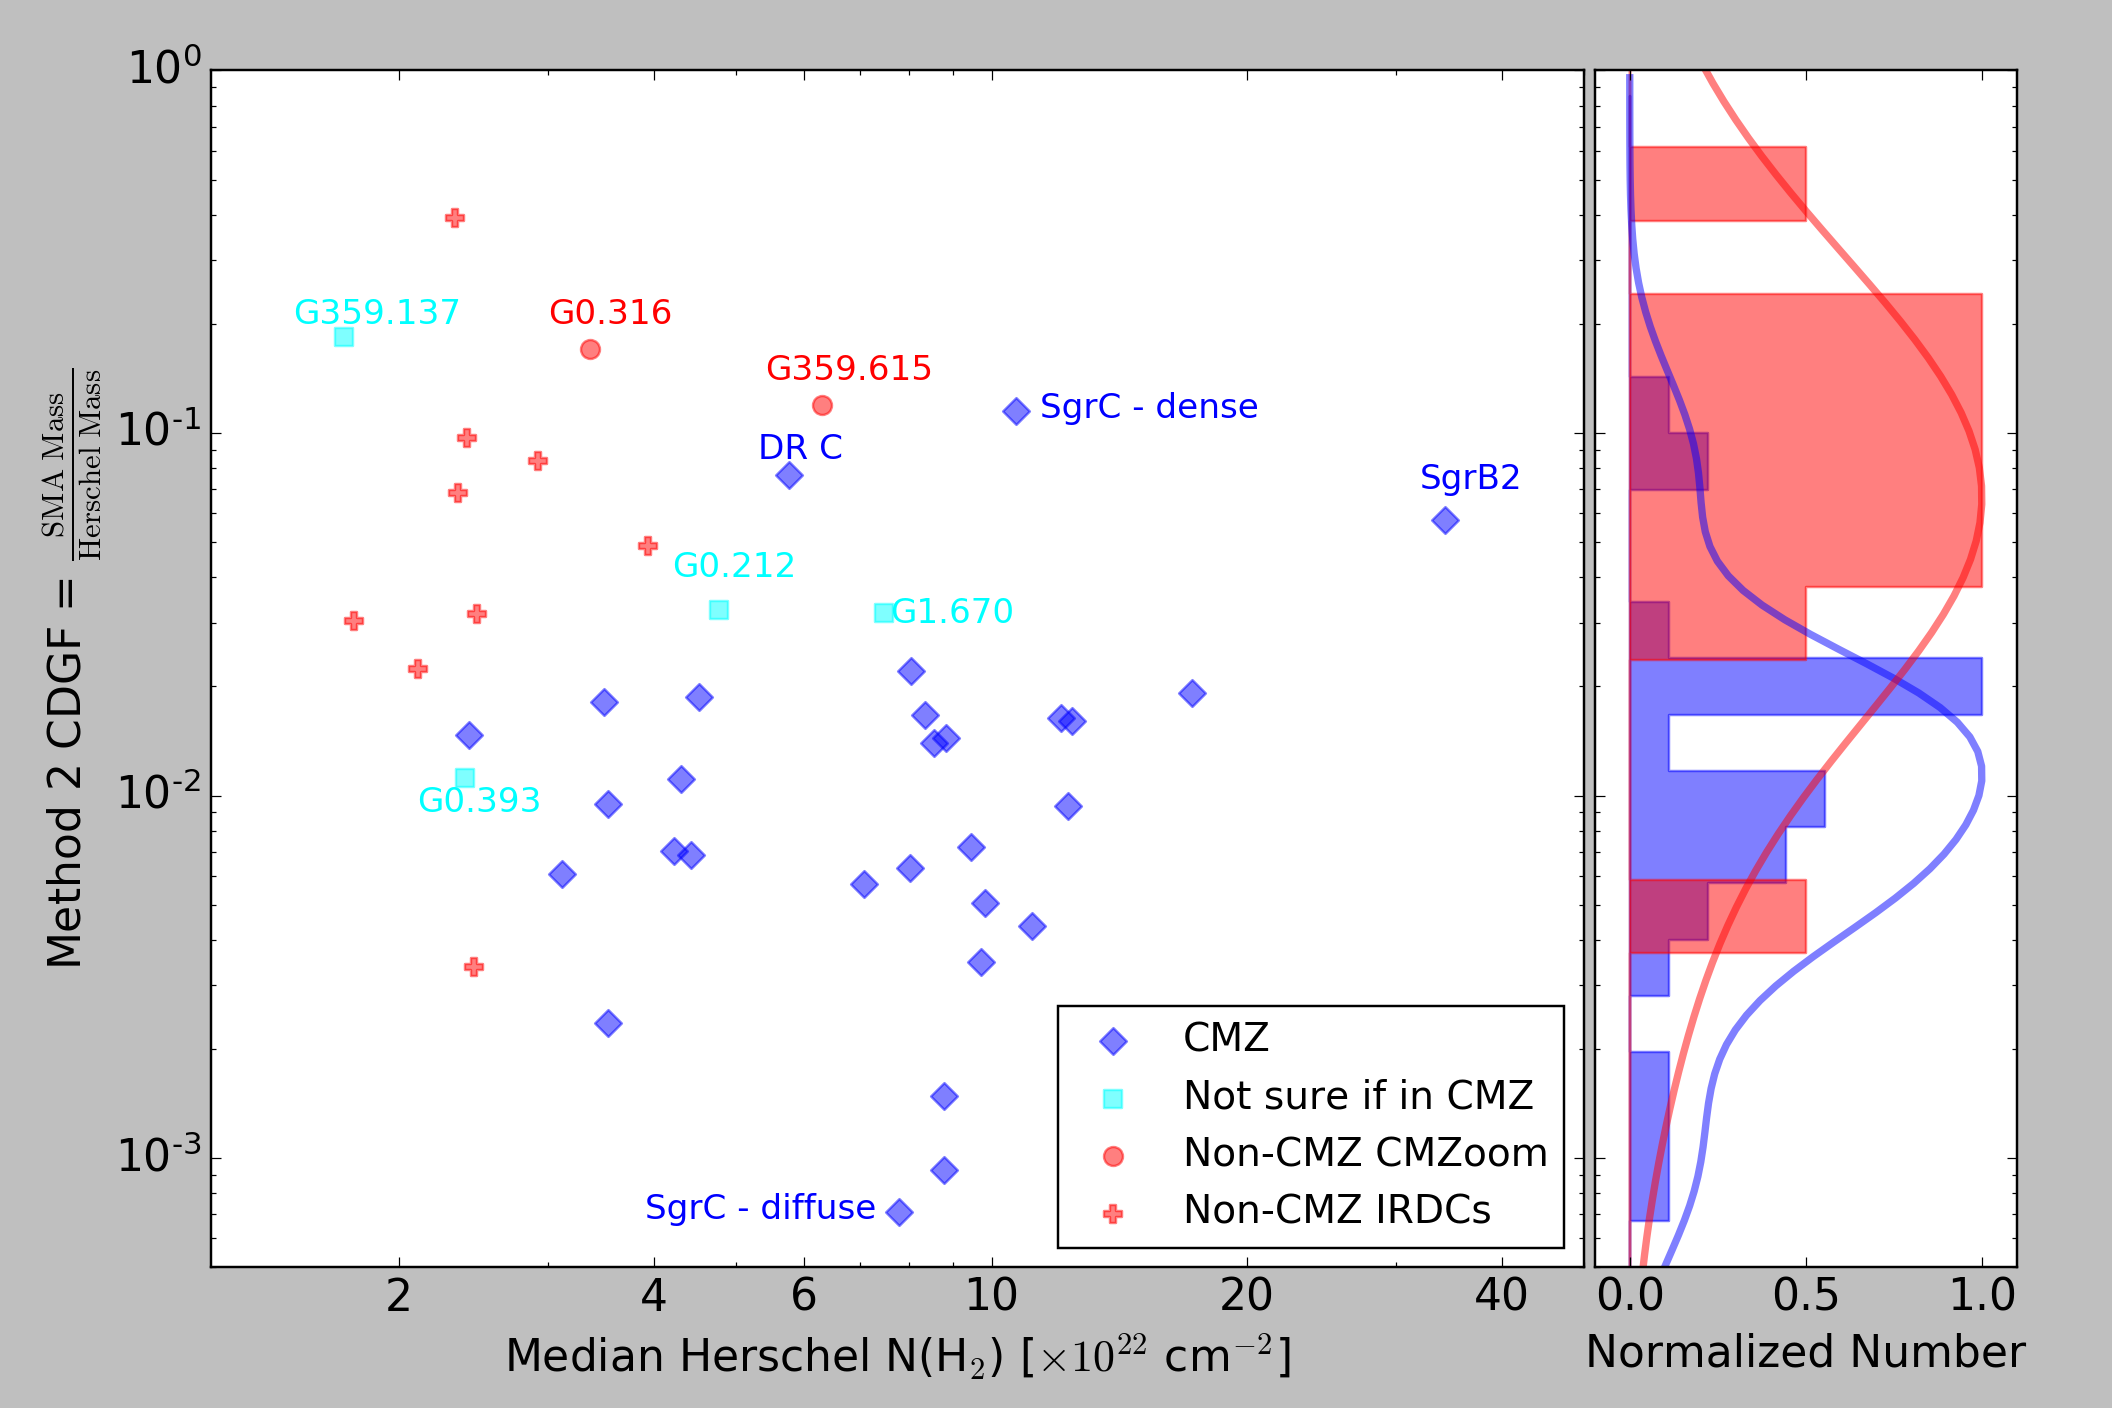

/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':
/Users/battersby/Dropbox/CMZoom_Data//dense_gas_fraction/dgf_comparison/histograms.py:234: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins=='':


In [29]:
# METHOD 2 with HISTOGRAM and KDE

%matplotlib nbagg

plt.style.use('seaborn-colorblind')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.85
spacing = 0.005
alpha=0.5
linewidth=3
markersize=60

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.rcParams.update({'font.size': 18}) #set fontsize
fig = plt.figure(1, figsize=(12, 8))

ax_scatter = plt.axes(rect_scatter)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(Hnh2med_cmz/1e22, smp1_3sig_cmz, s=markersize, marker='D', color='blue', alpha=alpha, label=r'CMZ')
ax_scatter.scatter(Hnh2med_not/1e22, smp1_3sig_not, s=markersize, marker='s', color='cyan', alpha=alpha, label=r'Not sure if in CMZ')
ax_scatter.scatter(Hnh2med_non/1e22, smp1_3sig_non, s=markersize, marker='o', color='red', alpha=alpha,label=r'Non-CMZ CMZoom')
ax_scatter.scatter(Hnh2med_irdcs/1e22, ratio_irdcs, s=markersize, marker='P', color='red', alpha=alpha,label=r'Non-CMZ IRDCs')

# add one point for SgrC overall:
#ax_scatter.scatter(8.0, 0.02, marker='D', color='blue', alpha=alpha)#, label=r'CMZ')

ax_scatter.set_xlim([1.2, 50]) # divided by 1e22, changed to match method 1 x axis
ax_scatter.set_ylim((0.0005,1))
#ax_scatter.set_ylabel(r'Dense Gas Fraction = $\frac{\rm{SMA\ Mass}}{\rm{Herschel\ Mass}}$')
ax_scatter.set_ylabel(r'Method 2 CDGF = $\frac{\rm{SMA\ Mass}}{\rm{Herschel\ Mass}}$')
ax_scatter.set_xlabel(r'Median Herschel N(H$_2$) [$\times 10^{22}$ cm$^{-2}$]')
ax_histy.set_xlabel(r'Normalized Number')
ax_histy.xaxis.set_ticks(np.arange(0, 1.5, 0.5))
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')

# Add more x tick labels
ax_scatter.set_xticks([2, 4, 6, 10, 20, 40])
ax_scatter.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#### CMZ
# Histogram
data = smp1_3sig_cmz
bins = np.logspace(np.log(5e-4), np.log(1), num=50)
_, bin_cent1, hist1 = histograms.get_hist(data, bins=bins, norm=True)
ax_histy.fill_between(hist1, 0, bin_cent1, color='blue', alpha=alpha, step='pre') # To fill the histogram
#ax_histy.plot(hist1, bin_cent1, color='blue', ds='steps', alpha=alpha) # To outline the histogram
# KDE
offset = 4
data_log = np.log10(data)+offset
bins2 = np.linspace(0, 4, 100)
_, bin_cent2_log, hist2 = histograms.get_histkde(data_log, norm=True, bins=bins2)
bin_cent2 = 10**(bin_cent2_log-offset)
ax_histy.plot(hist2, bin_cent2, color='blue', alpha=alpha, linewidth=linewidth) # To outline the KDE
#ax_histy.fill_between(hist2, 0, bin_cent2, color='red', alpha=0.5, step='mid') # To fill the KDE

#### NON CMZ
#non CMZ
data=ratio2_noncmz
bins = np.logspace(np.log(5e-4), np.log(10), num=50)
_, bin_cent1, hist1 = histograms.get_hist(data, bins=bins, norm=True)
ax_histy.fill_between(hist1, 0, bin_cent1, color='red', alpha=alpha, step='pre') # To fill the histogram
#ax_histy.plot(hist1, bin_cent1, color='red', ds='steps', alpha=alpha) # To outline the histogram
# KDE
offset = 4
data_log = np.log10(data)+offset
bins2 = np.linspace(0, 5, 100)
_, bin_cent2_log, hist2 = histograms.get_histkde(data_log, norm=True, bins=bins2)
bin_cent2 = 10**(bin_cent2_log-offset)
ax_histy.plot(hist2, bin_cent2, color='red', alpha=alpha, linewidth=linewidth) # To outline the KDE
#ax_histy.fill_between(hist2, 0, bin_cent2, color='red', alpha=0.5, step='mid') # To fill the KDE


# Set histogram axes
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim([-0.1, 1.1])

#label individual points in CMZ
ax_scatter.text(32, 0.07, 'SgrB2', color='blue', fontsize=14)
ax_scatter.text(5.3, 0.085, 'DR C', color='blue', fontsize=14)
#ax_scatter.text(8.0, 0.02, 'SgrC - overall', color='blue', fontsize=14)
ax_scatter.text(3.9, 0.00068, 'SgrC - diffuse', color='blue', fontsize=14)
ax_scatter.text(11.4, 0.11, 'SgrC - dense', color='blue', fontsize=14)
#ax_scatter.text(10, 0.017, '20 km/s', color='blue', fontsize=14) -- too close to the other points!

# Label ones we are not sure if they are CMZ or not
ax_scatter.text(1.5, 0.2, 'G359.137', color='cyan', fontsize=14)
ax_scatter.text(4.2, 0.04, 'G0.212', color='cyan', fontsize=14)
ax_scatter.text(2.1, 0.009, 'G0.393', color='cyan', fontsize=14)
#ax_scatter.text(6.5, 0.06, 'G1.670', color='cyan', fontsize=14)
ax_scatter.text(7.6, 0.03, 'G1.670', color='cyan', fontsize=14)

# Definitely NOT CMZ
ax_scatter.text(5.4, 0.14, 'G359.615', color='red', fontsize=14)
ax_scatter.text(3.0, 0.20, 'G0.316', color='red', fontsize=14)

ax_scatter.legend(loc='lower right', shadow=False, fontsize=16, frameon=True, scatterpoints=1)

plt.show()

plt.savefig(pathfig+'CMZoom_dgf_sma_over_herschel_cmz_disk_histogram_kde.pdf',
            format='pdf', dpi=500, bbox_inches='tight')

In [30]:
### Write a LaTeX table:

cloud_names=['G1.683-0.089', 'G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 
             'G1.038-0.074', 'G0.891-0.048', 'G0.714-0.100', 'G0.699-0.028','G0.619+0.012', 
             'G0.489+0.010', 'G0.412+0.052', 'G0.393-0.034', 'G0.380+0.050','G0.340+0.055', 
             'G0.326-0.085', 'G0.316-0.201', 'G0.253+0.016','G0.212-0.001', 'G0.145-0.086', 
             'G0.106-0.082', 'G0.070-0.035', 'G0.068-0.075','G0.054+0.027', 'G0.014+0.021', 
             'G0.001-0.058', 'G359.948-0.052', 'G359.889-0.093','G359.865+0.022', 
             'G359.734+0.002', 'G359.648-0.133', 'G359.611+0.018', 'G359.615-0.243',
             'G359.484-0.132', 'G359.137+0.031', 'G359.484-0.132 Dense']

cloud_abbrev_nomask = ['1.6$^{\circ}$','1.6$^{\circ}$','1.6$^{\circ}$','1.6$^{\circ}$',
             '1.1$^{\circ}$','1.1$^{\circ}$','1.1$^{\circ}$','SgrB2ext', 'SgrB2', 'SgrB2NW',
             'DR e/f','DR d','HMSFR','DR c','DR b',
             'FSC','HMSFR','Brick','HMSFR',
             'Straw','Sticks','Bridge','Stone','Arches w1','Arches e1',
             '50km/s','CND','20km/s','FSC','FSC',
             'stream','FSC','HMSFR','SgrC','HMSFR','SgrC dense']

##Put in Units:
Hnh2med = Hnh2med / (u.cm)**2
S_flux3sig = S_flux3sig * u.Jy / u.pix
B_flux3sig = B_flux3sig * u.Jy / u.pix
smacloudmass1_3sig = smacloudmass1_3sig * u.Msun
mtot1 = mtot1 * u.Msun

t = QTable([np.arange(1,nel+1),cloud_names, cloud_abbrev_nomask, Hnh2med,S_flux3sig, B_flux3sig,  
            smacloudmass1_3sig, mtot1, (S_flux3sig/B_flux3sig), smp1_3sig], 
             names=('Mask \#', 'Cloud Names','Abbrev.','Median N(H$_2$)',
                    'SMA Flux', 'BGPS Flux', 'SMA Mass', 'Herschel Mass', 
                    'DGF method1', 'DGF method2'))

t['Median N(H$_2$)'].info.format = "{0:.2g}"
t['SMA Flux'].info.format = "{0:.2g}"
t['BGPS Flux'].info.format = "{0:.2g}"
t['SMA Mass'].info.format = "{0:.2g}"
t['Herschel Mass'].info.format = "{0:.2g}"
#t['DGF method1'].info.format = "{0:.2f}"
#t['DGF method2'].info.format = "{0:.2f}"
#t['DGF method1'].info.format = "{0:2.1f}"
#t['DGF method2'].info.format = "{0:2.1f}"
#t['DGF method1'].info.format = "{0:.3f}"
#t['DGF method2'].info.format = "{0:.3f}"
t['DGF method1'].info.format = "{0:.2g}"
t['DGF method2'].info.format = "{0:.2g}"

### Maybe there is a fix (??) but as of now, just go into the table and delete "\begin{table} and \end{table}"
# to get it to compile properly in latex (with label and caption set in latex not here)
# Also need to delete unit, since they are ... nonsense after this box is run multiple times (keeps adding units).
# add in lines to make it prettier...
# Save final table as DGF_table_FINAL.tex, do modifications there.

#Table took too much finagling, this is just the general version, the "final" one is hand-tweaked
pathtable2 = '/Users/battersby/Dropbox/Work/cmz/cmzoom_overview/overleaf_cmzoom/not_used_other_versions_of_overleaf_things/other_table_versions/'
t.write(pathtable2+'DGF_table.tex', format='latex',overwrite=True)

t


Mask \#,Cloud Names,Abbrev.,Median N(H$_2$),SMA Flux,BGPS Flux,SMA Mass,Herschel Mass,DGF method1,DGF method2
,,,1 / cm2,Jy / pix,Jy / pix,solMass,solMass,,
int64,str20,str13,float64,float64,float64,float64,float64,float64,float64
1,G1.683-0.089,1.6$^{\circ}$,7.1e+22,0.12,2.4,2.3e+02,4e+04,0.051,0.0057
2,G1.670-0.130,1.6$^{\circ}$,7.5e+22,0.59,2.6,1.1e+03,3.4e+04,0.22,0.032
3,G1.651-0.050,1.6$^{\circ}$,9.8e+22,0.29,7.9,6.1e+02,1.2e+05,0.037,0.005
4,G1.602+0.018,1.6$^{\circ}$,9.5e+22,0.4,12,8e+02,1.1e+05,0.033,0.0072
5,G1.085-0.027,1.1$^{\circ}$,9.7e+22,0.34,12,5.7e+02,1.6e+05,0.028,0.0035
6,G1.038-0.074,1.1$^{\circ}$,8.8e+22,0.1,13,1.7e+02,1.8e+05,0.0079,0.00093
7,G0.891-0.048,1.1$^{\circ}$,8.8e+22,0.33,31,4.9e+02,3.3e+05,0.011,0.0015
8,G0.714-0.100,SgrB2ext,1.2e+23,3.1,78,4.4e+03,4.7e+05,0.04,0.0093
